# Classification

Import the libraries necessary to analize data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
import scikitplot as skplt
import seaborn as sns
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import precision_score, recall_score, classification_report
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_csv('../Task1/df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

In [3]:
#check if there is any null value
df.isnull().values.any()

False

The calssification task requires to predict whether in the incident there were killed people. Hence we create the binary attribute isKilled

In [4]:
df['isKilled'] = np.where(df['n_killed'] > 0, 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

## Discretize categorical values

We discretize the categorical values to use them in the classification task

In [5]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
to_discretize = ['date', 'state', 'city_or_county', 'party']
df = discretize_data(df, to_discretize)

Dropping non-discretized columns

In [7]:
df.drop(columns=['date', 'state', 'city_or_county', 'party'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   166664 non-null  float64
 1   longitude                  166664 non-null  float64
 2   congressional_district     166664 non-null  int64  
 3   avg_age_participants       166664 non-null  float64
 4   n_participants_child       166664 non-null  int64  
 5   n_participants_teen        166664 non-null  int64  
 6   n_females                  166664 non-null  float64
 7   n_killed                   166664 non-null  float64
 8   n_injured                  166664 non-null  float64
 9   n_arrested                 166664 non-null  float64
 10  n_unharmed                 166664 non-null  float64
 11  n_participants             166664 non-null  float64
 12  incident_characteristics1  166664 non-null  object 
 13  povertyPercentage          16

## Eliminating dependent columns

<Axes: >

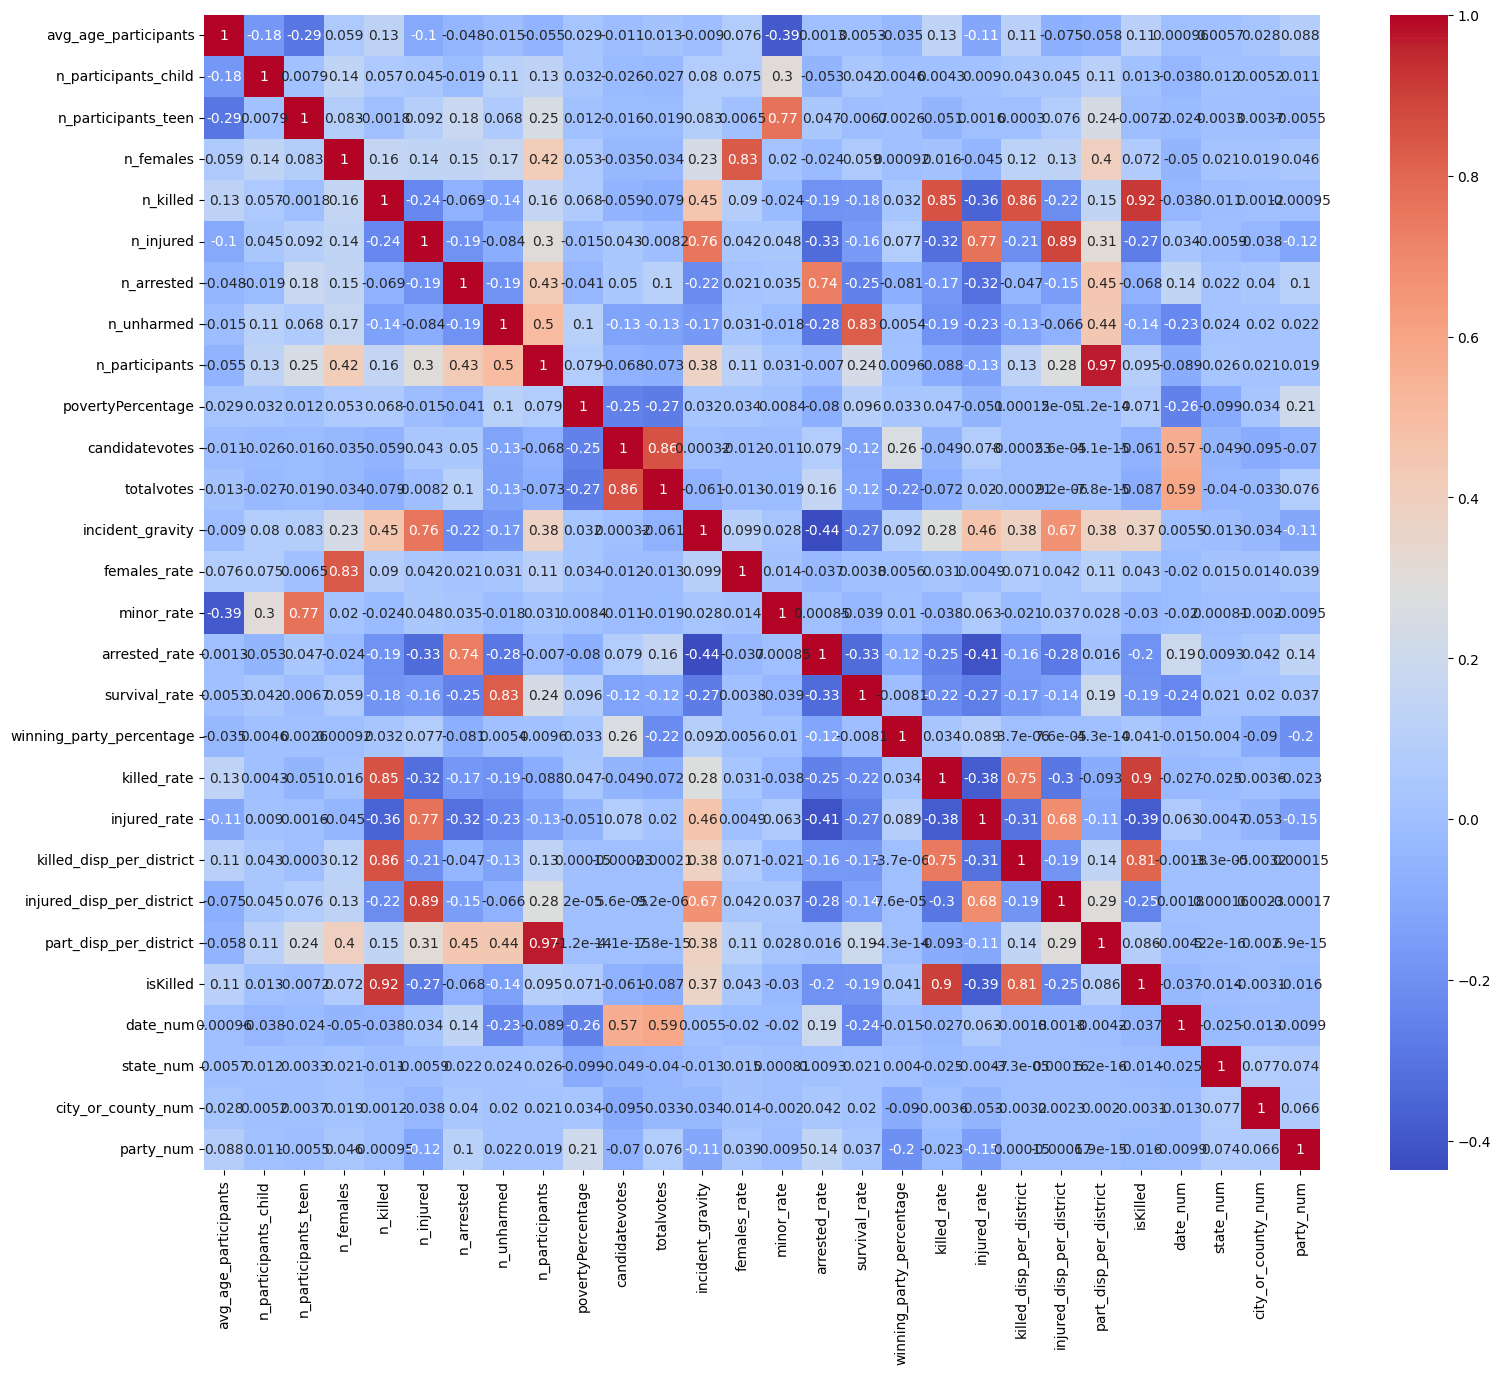

In [8]:
col_to_plot = [i for i in list(df.columns) if i not in ['latitude', 'longitude', 'date','congressional_district']] 
corr_matrix_ind = df[col_to_plot].corr(numeric_only=True, method='pearson')
plt.figure(figsize=(18,15))
sns.heatmap(corr_matrix_ind, annot=True, cmap='coolwarm')

In [9]:
df[(df['n_killed'] == (df["n_participants"] - (df["n_injured"] + df["n_unharmed"] + df["n_arrested"])))][["n_participants","n_killed","n_injured","n_unharmed","n_arrested"]]

n_participants  n_killed  n_injured  n_unharmed  n_arrested
0                  1.0       0.0        0.0         0.0         1.0
1                  1.0       0.0        0.0         0.0         1.0
2                  1.0       0.0        0.0         0.0         1.0
3                  1.0       1.0        0.0         0.0         0.0
4                  1.0       0.0        0.0         0.0         1.0
...                ...       ...        ...         ...         ...
166659             3.0       0.0        0.0         3.0         0.0
166660             3.0       0.0        0.0         3.0         0.0
166661             3.0       0.0        1.0         2.0         0.0
166662             5.0       0.0        3.0         2.0         0.0
166663             5.0       0.0        4.0         0.0         1.0

[157302 rows x 5 columns]

We drop all the cluster indicators as they are all highly correlated with original features, moreover we decide to drop also latitude and longitude as they represent a sort of incident id (each incident has a unique couple of values after the data preparation), n_killed because highly correlated with isKilled, candidatevotes and totalvotes because they are irrilevant and add only further details to the majority winning party represented already by the attribute party. 

We eliminate also incident_characteristics1 because we think it will simplify too much the task providing a label for each incident.

Moreover, as:

1- so far in the dataset almost the total number of records respect a linear relation n_killed (highly correlated with isKilled) == (df["n_participants"] - (df["n_injured"] + df["n_unharmed"] + df["n_arrested"])) as observed above;

2- we verified that simple baseline methods like logistic regression and k-nn with this setting of features reach above almost 95% of accuracy and 90% of precision, recall, f1, 

we decide to drop also n_injured and n_unharmed, because we consider them harder to find by police w.r.t. n_arrested, as they can grow in time and can be uncertain, and we prefer to leave more general information represented by n_participants.


In [10]:
col_to_drop = ['latitude', 'longitude', 'n_killed', 'n_injured', 'n_unharmed', 'candidatevotes', 'totalvotes', 'incident_characteristics1', 'incident_gravity', 'females_rate',
       'minor_rate', 'arrested_rate', 'survival_rate',  'killed_rate', 'injured_rate',
       'killed_disp_per_district', 'injured_disp_per_district',
       'part_disp_per_district', 'winning_party_percentage']

df.drop(columns=col_to_drop, axis=1,inplace=True)

<Axes: >

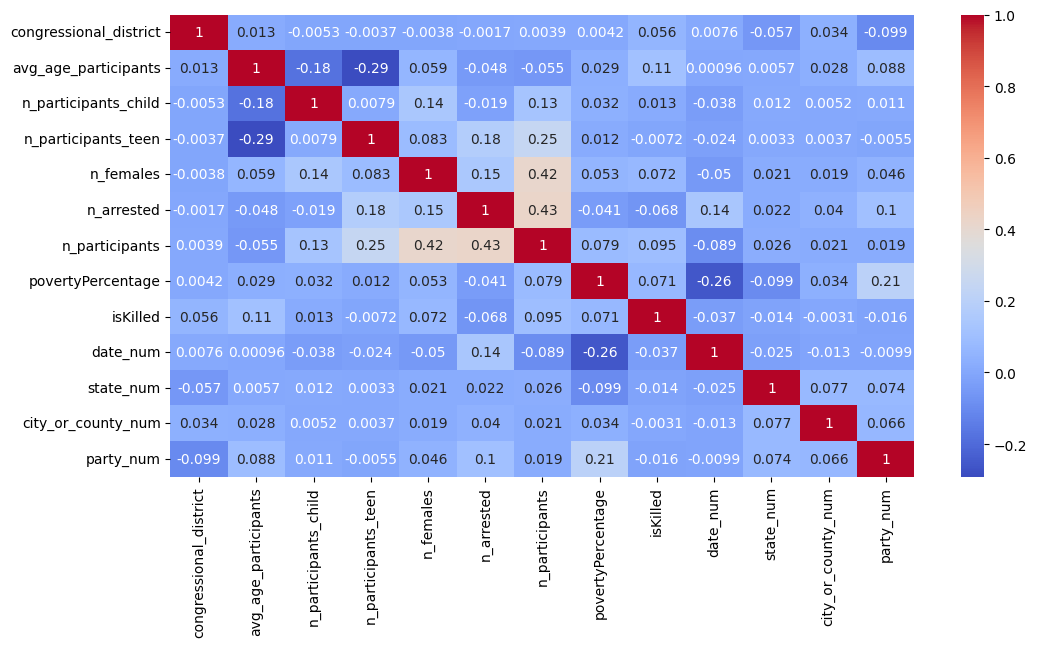

In [11]:
plt.figure(figsize=(12,6))
corr_matrix_ind = df.corr(numeric_only=True, method='pearson')
corr_matrix_ind
sns.heatmap(corr_matrix_ind, annot=True, cmap='coolwarm')

## Classification setup

Check label distribution in order to understand if our dataset is unbalanced towards the negative label (no kill), 23% of labels is positive indeed. 

In [12]:
df['isKilled'].value_counts(True)

isKilled
0    0.736896
1    0.263104
Name: proportion, dtype: float64

Defining a "label" variable for using stratified methods

In [13]:
label = df.pop('isKilled')

We partitioned the dataset into training, validation, and test sets using a 70/30 split.

In [14]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.30,random_state=10, stratify=label)

We standardize data and use oversampling and undersampling techniques to help classification methods to perform better 

over/undersampling on scaled dataset

In [15]:
scaler = StandardScaler()
X_sc_trvl = scaler.fit_transform(X_trvl)
X_sc_test = scaler.fit_transform(X_test)

print(y_trvl.value_counts(True))


oversample = RandomOverSampler(sampling_strategy='minority',random_state=15)
X_sc_trvl_oversampled, y_trvl_oversampled = oversample.fit_resample(X_sc_trvl, y_trvl)
print(y_trvl_oversampled.value_counts(True))


undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_sc_trvl_undersample, y_trvl_undersample = oversample.fit_resample(X_sc_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))


isKilled
0    0.736894
1    0.263106
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64


over/undersampling on not scaled dataset

In [16]:
print(y_trvl.value_counts(True))


oversample = RandomOverSampler(sampling_strategy='minority',random_state=15)
X_trvl_oversampled, y_trvl_oversampled = oversample.fit_resample(X_trvl, y_trvl)
print(y_trvl_oversampled.value_counts(True))


undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_trvl_undersample, y_trvl_undersample = oversample.fit_resample(X_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))

isKilled
0    0.736894
1    0.263106
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64
isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64


In [17]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Defining some utility functions

In [18]:
def print_metrics_cv(results_hp_search, model_name):
    index_best_model = results_hp_search.best_index_ 
    results_dict = results_hp_search.cv_results_
    metrics_list=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    if model_name == 'MLP':
        metrics_list.append('mse')
    print(f"CV best configuration for {model_name}:")
    print(f"best parameters {results_dict['params'][index_best_model]}")
    for i in metrics_list:        
        if i == 'mse':
            print(f'Mean {i} train set: {abs(results_dict[f"mean_train_{i}"][index_best_model])} +/- {results_dict[f"std_train_{i}"][index_best_model]}')
            continue
        print(f'Mean {i} train set: {results_dict[f"mean_train_{i}"][index_best_model]} +/- {results_dict[f"std_train_{i}"][index_best_model]}')
    print("\n")
    for i in metrics_list:
        if i == 'mse':
            print(f'Mean {i} train set: {abs(results_dict[f"mean_test_{i}"][index_best_model])} +/- {results_dict[f"std_test_{i}"][index_best_model]}')
            continue
        print(f'Mean {i} validation set: {results_dict[f"mean_test_{i}"][index_best_model]} +/- {results_dict[f"std_test_{i}"][index_best_model]}')
    print("\n")

In [19]:
# Function that prints the classification report
def print_report_score(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['NotKilled', 'isKilled']))

# Function that prints the confusion matrix
def print_confusion_matrix(test_label, pred_label, model):
    cm = confusion_matrix(test_label, pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

In [20]:
# Function extracting each grid from dictionary of grids
def list_grids(grids_dict):
    return [grids_dict[item] for item in grids_dict]

# Function performing gridsearch cv according to sklearn
def do_sklearn_GridSearchCV(model_name,model,param_grid,scoring,refit,cv,return_train_score,n_jobs,X_encoded,y):
    hp_search = GridSearchCV(model,
                                param_grid=param_grid,
                                scoring=scoring,
                                refit=refit,
                                cv=cv,
                                return_train_score=return_train_score,
                                n_jobs=n_jobs,
                                verbose=10
                                ).fit(X_encoded, y)


    results = pd.DataFrame(hp_search.cv_results_)
    if not os.path.isdir(f"cv_results/"):
        os.mkdir(f"cv_results/")

    results.to_csv(f"cv_results/{model_name}_cv_results.csv")

    return hp_search

## Logistic Regression

In [54]:


params = {
       "l1": {"solver": ['saga', 'liblinear'],
              "C": [1e-1, 1e1, 1e4],
              "penalty": ['l1'],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
              },
       "l2": {"solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
              "C": [1e-1, 1e1, 1e4],
              "penalty": ['l2'],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
              },
       "elastic-net": {"solver": ['saga'],
                     "C": [1e-1, 1e1, 1e4],
                     "penalty": ['elasticnet'],
                     "l1_ratio": np.arange(0.0, 1.1, 0.1),
                     "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}, {0:1,1:100}]
                     }, 
       "None": {"solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              "penalty": [None],
                     "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
              }
}

best_logit = do_sklearn_GridSearchCV("LogisticRegression",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [53]:
#df_logit = pd.DataFrame(best_logit.cv_results_)
#df_logit.sort_values(by="rank_test_accuracy")[["params", "rank_test_accuracy",  "mean_train_accuracy", "mean_test_accuracy", "mean_test_precision",  "mean_train_precision","mean_test_recall", "mean_test_f1", "mean_test_roc_auc"]]

CV best configuration for LogisticRegression:
best parameters {}
Mean accuracy train set: 0.7591012629279722 +/- 0.00022464332633749661
Mean precision train set: 0.38818664535504654 +/- 0.0029430255600757967
Mean recall train set: 0.052508551881413915 +/- 0.0009843238749168242
Mean f1 train set: 0.09250149852021394 +/- 0.0015653627019491338
Mean roc_auc train set: 0.6936978127590997 +/- 0.0007341544138101186


Mean accuracy validation set: 0.7591964938512802 +/- 0.000853352868558791
Mean precision validation set: 0.3893729679607542 +/- 0.01153254121834656
Mean recall validation set: 0.05241896074279199 +/- 0.0014908045204297168
Mean f1 validation set: 0.09239171276349305 +/- 0.0025169760531244144
Mean roc_auc validation set: 0.6933931550725043 +/- 0.002716750480546887


Testing:
              precision    recall  f1-score   support

   NotKilled       0.77      0.97      0.86     43106
    isKilled       0.37      0.05      0.09     13155

    accuracy                           0.76   

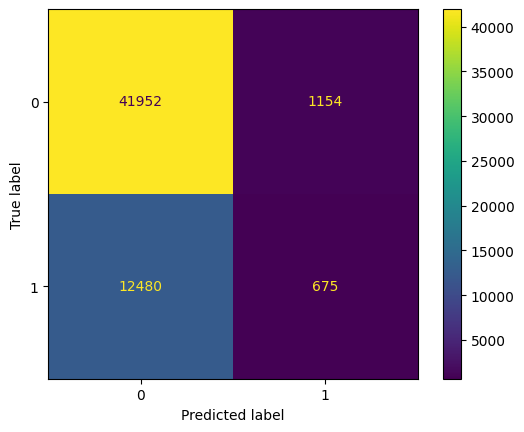

In [55]:
print_metrics_cv(best_logit,"LogisticRegression")
print("Testing:")
test_pred_logit = best_logit.predict(X_sc_test)

print_report_score(y_test,test_pred_logit)
print_confusion_matrix(y_test,test_pred_logit,best_logit)

Oversampling

In [57]:
best_logit_ov = do_sklearn_GridSearchCV("LogisticRegression_OV",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for LogisticRegression_OV:
best parameters {}
Mean accuracy train set: 0.6294107553270109 +/- 0.0006211236851399809
Mean precision train set: 0.6442615754228112 +/- 0.0008451314341502514
Mean recall train set: 0.5779419971793561 +/- 0.0005655670569181463
Mean f1 train set: 0.6093021089729528 +/- 0.0005251688342370451
Mean roc_auc train set: 0.7023494417043914 +/- 0.00040030732871749704


Mean accuracy validation set: 0.6292131327446 +/- 0.0017978456384828629
Mean precision validation set: 0.644103511896803 +/- 0.0022001591857258745
Mean recall validation set: 0.5775616472928305 +/- 0.0025052202192168594
Mean f1 validation set: 0.6090171723583081 +/- 0.0019445894974507306
Mean roc_auc validation set: 0.7021900270021858 +/- 0.0015522253029819208


Testing:
              precision    recall  f1-score   support

   NotKilled       0.84      0.68      0.75     43106
    isKilled       0.35      0.58      0.44     13155

    accuracy                           0.65     5

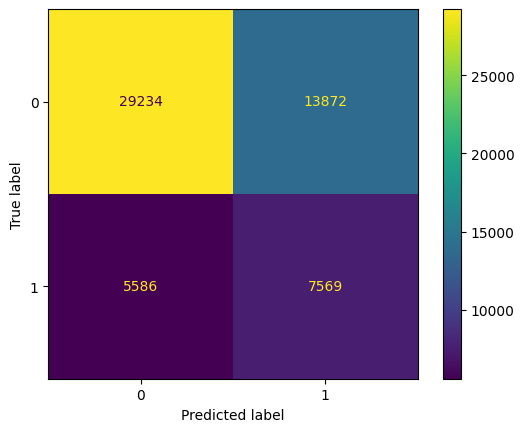

In [58]:
print_metrics_cv(best_logit_ov,"LogisticRegression_OV")
print("Testing:")
test_pred_logit_ov = best_logit_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_logit_ov)
print_confusion_matrix(y_test,test_pred_logit_ov,best_logit_ov)

Undersampling

In [59]:
best_logit_und = do_sklearn_GridSearchCV("LogisticRegression_UN",LogisticRegression(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for LogisticRegression_UN:
best parameters {}
Mean accuracy train set: 0.6294107553270109 +/- 0.0006211236851399809
Mean precision train set: 0.6442615754228112 +/- 0.0008451314341502514
Mean recall train set: 0.5779419971793561 +/- 0.0005655670569181463
Mean f1 train set: 0.6093021089729528 +/- 0.0005251688342370451
Mean roc_auc train set: 0.7023494417043914 +/- 0.00040030732871749704


Mean accuracy validation set: 0.6292131327446 +/- 0.0017978456384828629
Mean precision validation set: 0.644103511896803 +/- 0.0022001591857258745
Mean recall validation set: 0.5775616472928305 +/- 0.0025052202192168594
Mean f1 validation set: 0.6090171723583081 +/- 0.0019445894974507306
Mean roc_auc validation set: 0.7021900270021858 +/- 0.0015522253029819208


Testing:
              precision    recall  f1-score   support

   NotKilled       0.84      0.68      0.75     43106
    isKilled       0.35      0.58      0.44     13155

    accuracy                           0.65     5

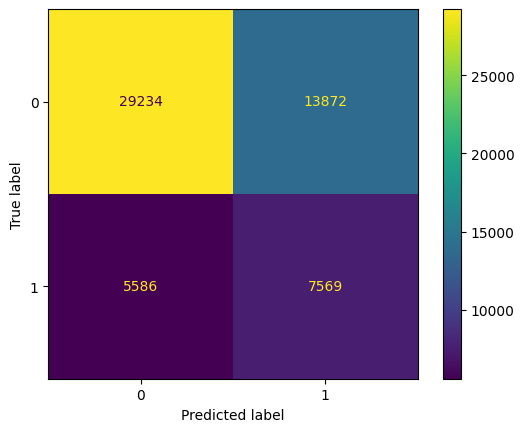

In [60]:
print_metrics_cv(best_logit_und,"LogisticRegression_UN")
print("Testing:")
test_pred_logit_und = best_logit_und.predict(X_sc_test)

print_report_score(y_test,test_pred_logit_und)
print_confusion_matrix(y_test,test_pred_logit_und,best_logit_und)

## KNN

KNN works using a distance function, but distance can not be applied to categorical data. We need to handle categorical values, for example we could drop them.

We define the KNN calssifier by specifying the algorithm and the distance metric to use and we fit it to our data.

In [25]:
metrics = [
    'euclidean', 
    'minkowski',
    'chebyshev',
    'cosine',
    ]
params = {
        "unique_entry":{
        'n_neighbors': [3,5,7,100,300,500],
        'algorithm':['auto','ball_tree'], 
        'metric':metrics, 
        'weights':["distance","uniform"],
        'p': [1] # to include also manhattan distance (only valid with minkowski distance)
        }}
         
best_knn = do_sklearn_GridSearchCV("KNeighborsClassifier",KNeighborsClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

We run the prediction and evaluate the performance scores for this model.

In [26]:
print_metrics_cv(best_knn,"KNeighborsClassifier")
print("Testing:")
test_pred_knn = best_knn.predict(X_sc_test)

print_report_score(y_test,test_pred_knn)
print_confusion_matrix(y_test,test_pred_knn,best_knn)

NameError: name 'best_knn' is not defined

In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_knn.values, s=25, cmap='YlGn')


Oversampled

In [ ]:
best_knn_ov = do_sklearn_GridSearchCV("KNeighborsClassifier_OV",KNeighborsClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


ValueError: Invalid parameter 'class_weight' for estimator KNeighborsClassifier(). Valid parameters are: ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'].

In [ ]:
print_metrics_cv(best_knn_ov,"KNeighborsClassifier_OV")
print("Testing:")
test_pred_knn_ov = best_knn_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_knn_ov)
print_confusion_matrix(y_test,test_pred_knn_ov,best_knn_ov)

Undersampled

In [ ]:
best_knn_und = do_sklearn_GridSearchCV("KNeighborsClassifier_UN",KNeighborsClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

In [ ]:
print_metrics_cv(best_knn_und,"KNeighborsClassifier_UN")
print("Testing:")
test_pred_knn_und = best_knn_und.predict(X_sc_test)

print_report_score(y_test,test_pred_knn_und)
print_confusion_matrix(y_test,test_pred_knn_und,best_knn_und)

## Naive Bayes

Bayes theorem is used to compute the probability of an instance belonging to a given class given some prior knowledge.
We fit the model on our training data.

We chose the best among the classifiers, based on validation set and tested it.

In [31]:
from sklearn.naive_bayes import GaussianNB


best_gnb_cv = do_sklearn_GridSearchCV("GaussianNB",GaussianNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [32]:
print_metrics_cv(results_hp_search=best_gnb_cv, model_name='GaussianNB')

CV best configuration for GaussianNB:
best parameters {}
Mean accuracy train set: 0.8561376012716553 +/- 0.0035473013302933965
Mean precision train set: 0.6621763148677855 +/- 0.004049480262748528
Mean recall train set: 0.7854536569473856 +/- 0.02400309163645098
Mean f1 train set: 0.7184101800513234 +/- 0.010757114523271955
Mean roc_auc train set: 0.8944901939462266 +/- 0.0014578464149025182


Mean accuracy validation set: 0.8558042771496602 +/- 0.0029912190692628756
Mean precision validation set: 0.6617281325255171 +/- 0.004005960021353937
Mean recall validation set: 0.7843296953901286 +/- 0.02315717210618791
Mean f1 validation set: 0.717664274766181 +/- 0.009719306248916313
Mean roc_auc validation set: 0.8943219870533088 +/- 0.0012664817752625834




In [33]:
from sklearn.naive_bayes import BernoulliNB

best_bnb_cv = do_sklearn_GridSearchCV("BernoulliNB",BernoulliNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [34]:
print_metrics_cv(results_hp_search=best_bnb_cv, model_name='BernoulliNB')

CV best configuration for BernoulliNB:
best parameters {}
Mean accuracy train set: 0.7836779083816865 +/- 0.00014191271427727983
Mean precision train set: 0.9105209969137343 +/- 0.00747867859392625
Mean recall train set: 0.08303469620459357 +/- 0.0013378066290553631
Mean f1 train set: 0.15218379004750648 +/- 0.0021498949515216443
Mean roc_auc train set: 0.8284537680788695 +/- 0.0007738311421570178


Mean accuracy validation set: 0.783611265982674 +/- 0.0010334839304783497
Mean precision validation set: 0.9088568612025114 +/- 0.01189457070348238
Mean recall validation set: 0.0828473692783841 +/- 0.0037253734768327913
Mean f1 validation set: 0.15183926886673701 +/- 0.006416814959687437
Mean roc_auc validation set: 0.828303937013052 +/- 0.002991755753815365




In [35]:
from sklearn.naive_bayes import MultinomialNB

best_mnb_cv = do_sklearn_GridSearchCV("MultinomialNB",MultinomialNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [36]:
print_metrics_cv(results_hp_search=best_mnb_cv, model_name='MultinomialNB')

CV best configuration for MultinomialNB:
best parameters {}
Mean accuracy train set: 0.5514062334333043 +/- 0.004847453803732562
Mean precision train set: 0.2567267580953735 +/- 0.0015332736992575645
Mean recall train set: 0.4845496009122007 +/- 0.005088848108365343
Mean f1 train set: 0.33560846874834216 +/- 0.0002925382258287394
Mean roc_auc train set: 0.5398737332592107 +/- 0.003113599024505562


Mean accuracy validation set: 0.5514842587054087 +/- 0.008176526955790993
Mean precision validation set: 0.25695778708028577 +/- 0.005457827229910166
Mean recall validation set: 0.48506271379703536 +/- 0.006249148777128549
Mean f1 validation set: 0.33592431459003025 +/- 0.005577794576628838
Mean roc_auc validation set: 0.5398470451767194 +/- 0.01004791344262803




In [37]:
from sklearn.naive_bayes import ComplementNB

best_cnb_cv = do_sklearn_GridSearchCV("ComplementNB",ComplementNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s


In [38]:
print_metrics_cv(results_hp_search=best_cnb_cv, model_name='ComplementNB')

CV best configuration for ComplementNB:
best parameters {}
Mean accuracy train set: 0.534555851637033 +/- 0.002588212297309614
Mean precision train set: 0.255247075795776 +/- 0.001244937598224163
Mean recall train set: 0.5164847695064344 +/- 0.0006888851752334551
Mean f1 train set: 0.3416475244318182 +/- 0.0009802455891971885
Mean roc_auc train set: 0.5398652991414836 +/- 0.0031216579162174204


Mean accuracy validation set: 0.5351138093572979 +/- 0.005815021244656406
Mean precision validation set: 0.25552196204088407 +/- 0.004490235897756055
Mean recall validation set: 0.5163055872291904 +/- 0.007636606331053003
Mean f1 validation set: 0.34184926877393373 +/- 0.005458040099205391
Mean roc_auc validation set: 0.5398405870743987 +/- 0.010051289192042989




Best so far is GaussianNB, we testing it also with oversampling and undersampling techniques.

Testing:
              precision    recall  f1-score   support

   NotKilled       0.93      0.88      0.90     43106
    isKilled       0.66      0.78      0.72     13155

    accuracy                           0.86     56261
   macro avg       0.80      0.83      0.81     56261
weighted avg       0.87      0.86      0.86     56261



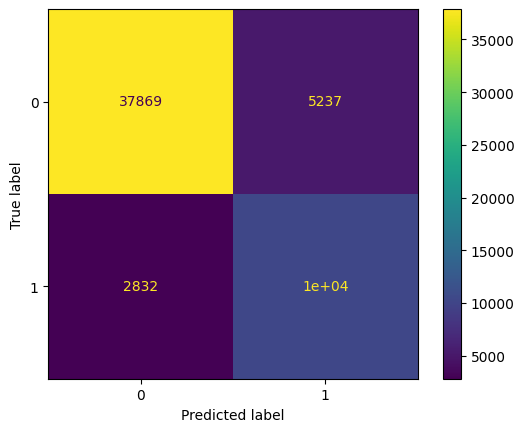

In [39]:
print("Testing:")
test_pred_gnb = best_gnb_cv.predict(X_test)
print_report_score(y_test,test_pred_gnb)
print_confusion_matrix(y_test,test_pred_gnb,best_gnb_cv)

oversampling

In [40]:
best_gnb_balanced_ov = do_sklearn_GridSearchCV("GaussianNB_OV",GaussianNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl_oversampled,y_trvl_oversampled)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


CV best configuration for GaussianNB_OV:
best parameters {}
Mean accuracy train set: 0.7472869350543025 +/- 0.0035881674653820204
Mean precision train set: 0.6755262791363921 +/- 0.0031232752368840237
Mean recall train set: 0.9517439259906961 +/- 0.0013639834406489074
Mean f1 train set: 0.7901899694428481 +/- 0.002579256998283355
Mean roc_auc train set: 0.8957640153162556 +/- 0.0009369164146972369


Mean accuracy validation set: 0.7469724862531922 +/- 0.005159216115391393
Mean precision validation set: 0.6752703022472477 +/- 0.004355558191444009
Mean recall validation set: 0.9515897879299813 +/- 0.002372455244529954
Mean f1 validation set: 0.7899607586952313 +/- 0.0037909706247199687
Mean roc_auc validation set: 0.8956185014373903 +/- 0.001499188440156002


Testing:
              precision    recall  f1-score   support

   NotKilled       0.78      0.93      0.85     43106
    isKilled       0.34      0.11      0.17     13155

    accuracy                           0.74     56261
   ma

c:\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


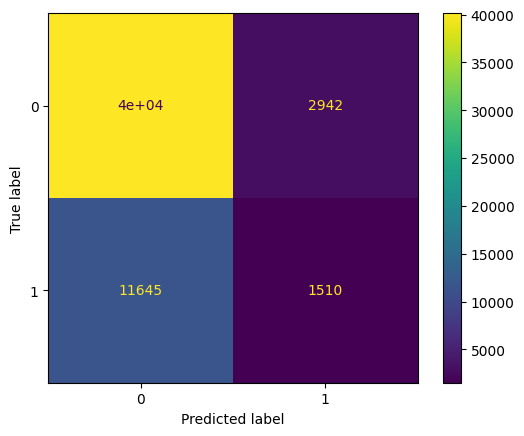

In [41]:
print_metrics_cv(best_gnb_balanced_ov,"GaussianNB_OV")
print("Testing:")
test_pred_gnb_over = best_gnb_balanced_ov.predict(X_test)

print_report_score(y_test,test_pred_gnb_over)
print_confusion_matrix(y_test,test_pred_gnb_over,best_gnb_balanced_ov)

Undersampling

In [42]:
best_gnb_balanced_und = do_sklearn_GridSearchCV("GaussianNB_UN",GaussianNB(),{}, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_trvl_undersample,y_trvl_undersample)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


CV best configuration for GaussianNB_UN:
best parameters {}
Mean accuracy train set: 0.7472869350543025 +/- 0.0035881674653820204
Mean precision train set: 0.6755262791363921 +/- 0.0031232752368840237
Mean recall train set: 0.9517439259906961 +/- 0.0013639834406489074
Mean f1 train set: 0.7901899694428481 +/- 0.002579256998283355
Mean roc_auc train set: 0.8957640153162556 +/- 0.0009369164146972369


Mean accuracy validation set: 0.7469724862531922 +/- 0.005159216115391393
Mean precision validation set: 0.6752703022472477 +/- 0.004355558191444009
Mean recall validation set: 0.9515897879299813 +/- 0.002372455244529954
Mean f1 validation set: 0.7899607586952313 +/- 0.0037909706247199687
Mean roc_auc validation set: 0.8956185014373903 +/- 0.001499188440156002


Testing:
              precision    recall  f1-score   support

   NotKilled       0.97      0.54      0.70     43106
    isKilled       0.39      0.95      0.55     13155

    accuracy                           0.64     56261
   ma

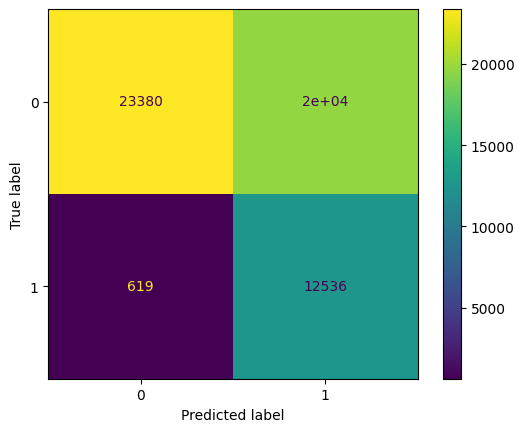

In [43]:
print_metrics_cv(best_gnb_balanced_ov,"GaussianNB_UN")
print("Testing:")
test_pred_gnb_und = best_gnb_balanced_und.predict(X_test)

print_report_score(y_test,test_pred_gnb_und)
print_confusion_matrix(y_test,test_pred_gnb_und,best_gnb_balanced_und)

We plotted the scatter plot for the classification values on the test set.

In [44]:
#plt.scatter(X_test.iloc[:, 5], X_test.iloc[:, 6], c=test_pred_gnb, s=25, cmap='YlGn')

## Decision tree

We fit the decision tree on our training data.

In [25]:
params = {
        "unique_entry": {
        'criterion': ['gini', 'entropy','log_loss'],
        'max_depth': [5,10,None],
        'max_features': ['sqrt', 'log2', None],
        'min_samples_split': [2,8,16,32],
        'min_samples_leaf': [1,2,4,8],
        "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}]
        }
        }
best_tree_cv = do_sklearn_GridSearchCV("DecisionTreeClassifier",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,4,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[CV 3/5; 1/1728] START class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2
[CV 2/5; 1/1728] START class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 1/1728] START class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2
[CV 4/5; 1/1728] START class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2
[CV 3/5; 1/1728] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; accuracy: (train=0.641, test=0.644) f1: (train=0.524, test=0.525) precision: (train=0.380, test=0.382) recall: (train=0.844, test=0.839) roc_auc: (train=0.774, test=0.773) total time=   0.1s
[CV 2/5; 1/1728] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; accurac

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5; 444/1728] END class_weight=None, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=32; accuracy: (train=0.775, test=0.774) f1: (train=0.131, test=0.130) precision: (train=0.677, test=0.654) recall: (train=0.072, test=0.072) roc_auc: (train=0.664, test=0.666) total time=   0.1s
[CV 3/5; 444/1728] END class_weight=None, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=32; accuracy: (train=0.767, test=0.767) f1: (train=0.023, test=0.020) precision: (train=0.584, test=0.598) recall: (train=0.012, test=0.010) roc_auc: (train=0.659, test=0.660) total time=   0.1s
[CV 4/5; 444/1728] END class_weight=None, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=32; accuracy: (train=0.766, test=0.766) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.713, test=0.709) total time=   0.1s
[CV 2/5; 444/1728] END class_we

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5; 456/1728] END class_weight=None, criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=32; accuracy: (train=0.766, test=0.766) f1: (train=0.000, test=0.000) precision: (train=1.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.663, test=0.659) total time=   0.1s
[CV 5/5; 456/1728] START class_weight=None, criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=32
[CV 2/5; 456/1728] END class_weight=None, criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=32; accuracy: (train=0.773, test=0.773) f1: (train=0.171, test=0.177) precision: (train=0.578, test=0.582) recall: (train=0.100, test=0.104) roc_auc: (train=0.721, test=0.717) total time=   0.1s
[CV 3/5; 456/1728] END class_weight=None, criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=32; accuracy: (train=0.766, test=0.766) f1: (train=0.000, test=0.000) precision: (train=0.000

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5; 464/1728] START class_weight=None, criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=32
[CV 5/5; 464/1728] START class_weight=None, criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=32
[CV 2/5; 464/1728] END class_weight=None, criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=32; accuracy: (train=0.767, test=0.767) f1: (train=0.009, test=0.007) precision: (train=0.753, test=0.657) recall: (train=0.005, test=0.004) roc_auc: (train=0.681, test=0.680) total time=   0.1s
[CV 1/5; 465/1728] START class_weight=None, criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 3/5; 464/1728] END class_weight=None, criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=32; accuracy: (train=0.766, test=0.766) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5; 596/1728] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=32; accuracy: (train=0.770, test=0.773) f1: (train=0.289, test=0.294) precision: (train=0.519, test=0.538) recall: (train=0.200, test=0.202) roc_auc: (train=0.748, test=0.753) total time=   0.1s
[CV 4/5; 597/1728] START class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2
[CV 1/5; 597/1728] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2; accuracy: (train=0.771, test=0.772) f1: (train=0.082, test=0.087) precision: (train=0.658, test=0.666) recall: (train=0.044, test=0.047) roc_auc: (train=0.706, test=0.705) total time=   0.1s
[CV 5/5; 597/1728] START class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2
[CV 2/5; 597/1728] END class_weight=None, criterion=entropy, max_depth=5, max_f

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5; 602/1728] START class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=8
[CV 4/5; 601/1728] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2; accuracy: (train=0.770, test=0.770) f1: (train=0.219, test=0.213) precision: (train=0.534, test=0.532) recall: (train=0.138, test=0.133) roc_auc: (train=0.720, test=0.715) total time=   0.1s
[CV 3/5; 602/1728] START class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=8
[CV 5/5; 601/1728] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2; accuracy: (train=0.770, test=0.770) f1: (train=0.074, test=0.074) precision: (train=0.634, test=0.635) recall: (train=0.039, test=0.039) roc_auc: (train=0.701, test=0.703) total time=   0.1s
[CV 4/5; 602/1728] START class_weight=None, criterion=entropy, max_depth=5, max_

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5; 607/1728] START class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=16
[CV 1/5; 608/1728] START class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=32
[CV 3/5; 607/1728] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=16; accuracy: (train=0.767, test=0.766) f1: (train=0.043, test=0.042) precision: (train=0.534, test=0.498) recall: (train=0.022, test=0.022) roc_auc: (train=0.630, test=0.627) total time=   0.1s
[CV 4/5; 607/1728] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=16; accuracy: (train=0.773, test=0.773) f1: (train=0.209, test=0.208) precision: (train=0.562, test=0.561) recall: (train=0.129, test=0.128) roc_auc: (train=0.749, test=0.744) total time=   0.1s
[CV 2/5; 608/1728] START class_weight=None, criterion=entropy, max_depth=5, 

In [36]:
print_metrics_cv(results_hp_search=best_tree_cv, model_name='DecisionTreeClassifier')

CV best configuration for DecisionTreeClassifier:
best parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 32}
Mean accuracy train set: 0.7959100501273486 +/- 0.003054541535780266
Mean precision train set: 0.6217129181992982 +/- 0.007666905561305806
Mean recall train set: 0.32655970027691805 +/- 0.04282741123108222
Mean f1 train set: 0.426271087634985 +/- 0.036310034239755005
Mean roc_auc train set: 0.8341676238656927 +/- 0.004574258866532058


Mean accuracy validation set: 0.7840454547742773 +/- 0.0009967541244678396
Mean precision validation set: 0.5737633777953559 +/- 0.011944025430638617
Mean recall validation set: 0.3033718846717707 +/- 0.040647801105388764
Mean f1 validation set: 0.39472239455132807 +/- 0.03383144632542796
Mean roc_auc validation set: 0.8135907549026307 +/- 0.0018000812447311674




This yields the following decision tree.

In [ ]:
""" dot_data = export_graphviz(best_tree_cv.best_estimator_, out_file=None, 
                         feature_names=list(X_trvl.columns),  
                         class_names=['0', '1'],
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) """

" dot_data = export_graphviz(best_tree_cv.best_estimator_, out_file=None, \n                         feature_names=list(X_trvl.columns),  \n                         class_names=['0', '1'],\n                         filled=True, rounded=True)  \ngraph = pydotplus.graph_from_dot_data(dot_data)  \nImage(graph.create_png()) "

The predicted values of TS, obtained using the decision tree are then computed.

Testing:
              precision    recall  f1-score   support

   NotKilled       0.81      0.91      0.86     43106
    isKilled       0.52      0.32      0.39     13155

    accuracy                           0.77     56261
   macro avg       0.66      0.61      0.63     56261
weighted avg       0.74      0.77      0.75     56261



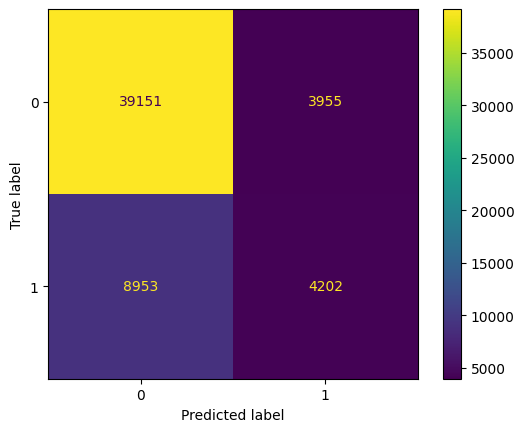

In [27]:
test_pred_dt = best_tree_cv.predict(X_sc_test)
print("Testing:")
print_report_score(y_test,test_pred_dt)
print_confusion_matrix(y_test, test_pred_dt, best_tree_cv)

In [ ]:
# TODO We plotted the scatter plot for the classification values on the test set 
#plt.scatter(X_sc_test.iloc[:, 5].values, X_sc_test.iloc[:, 2].values, c=test_pred_dt.values, s=25, cmap='YlGn')

Oversampling

In [ ]:
best_tree_balanced_ov = do_sklearn_GridSearchCV("DecisionTreeClassifier_OV",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .....................................criterion=gini; total time=   1.0s
[CV] END .....................................criterion=gini; total time=   1.1s
[CV] END .....................................criterion=gini; total time=   0.9s
[CV] END .....................................criterion=gini; total time=   0.7s
[CV] END .....................................criterion=gini; total time=   0.7s
[CV] END ..................................criterion=entropy; total time=   0.8s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END ..................................criterion=entropy; total time=   1.1s
[CV] END ..................................criterion=entropy; total time=   0.7s
[CV] END ..................................criterion=entropy; total time=   0.6s
[CV] END .................................criterion=log_loss; total time=   0.6s
[CV] END .................................criteri

CV best configuration for DecisionTreeClassifier_OV:
best parameters {'criterion': 'log_loss'}
Mean accuracy train set: 1.0 +/- 0.0
Mean precision train set: 1.0 +/- 0.0
Mean recall train set: 1.0 +/- 0.0
Mean f1 train set: 1.0 +/- 0.0
Mean roc_auc train set: 1.0 +/- 0.0


Mean accuracy validation set: 0.9920211171961343 +/- 0.0004534642959007463
Mean precision validation set: 0.9869819644214569 +/- 0.000969764326008422
Mean recall validation set: 0.9971962078063068 +/- 0.0005285457718015157
Mean f1 validation set: 0.9920623771313654 +/- 0.0004475992379445003
Mean roc_auc validation set: 0.9920211120022883 +/- 0.0004535648308297839


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     56261
   macro avg       0.98      0.97      0.98     56261
weighted avg       0.98      0.98      0.98     56261



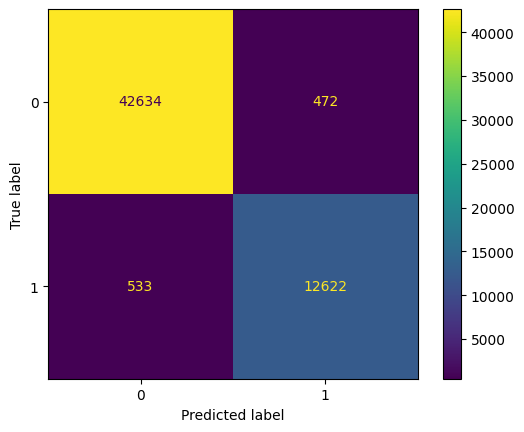

In [ ]:
print_metrics_cv(results_hp_search=best_tree_balanced_ov, model_name='DecisionTreeClassifier_OV')


print("Testing:")
test_pred_dt_over = best_tree_balanced_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_dt_over)
print_confusion_matrix(y_test,test_pred_dt_over,best_tree_balanced_ov)

Undersampling 

In [ ]:
best_tree_balanced_und = do_sklearn_GridSearchCV("DecisionTreeClassifier_UN",DecisionTreeClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,1,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .....................................criterion=gini; total time=   0.9s
[CV] END .....................................criterion=gini; total time=   1.2s
[CV] END .....................................criterion=gini; total time=   1.1s
[CV] END .....................................criterion=gini; total time=   1.0s
[CV] END .....................................criterion=gini; total time=   1.0s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END ..................................criterion=entropy; total time=   0.8s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END ..................................criterion=entropy; total time=   0.9s
[CV] END .................................criterion=log_loss; total time=   0.8s
[CV] END .................................criteri

CV best configuration for DecisionTreeClassifier_UN:
best parameters {'criterion': 'entropy'}
Mean accuracy train set: 1.0 +/- 0.0
Mean precision train set: 1.0 +/- 0.0
Mean recall train set: 1.0 +/- 0.0
Mean f1 train set: 1.0 +/- 0.0
Mean roc_auc train set: 1.0 +/- 0.0


Mean accuracy validation set: 0.9921951115090231 +/- 0.0004482566232409697
Mean precision validation set: 0.9873506314193156 +/- 0.0009048326284224864
Mean recall validation set: 0.9971663808029264 +/- 0.000535417892909882
Mean f1 validation set: 0.99223386772385 +/- 0.00044319813556801234
Mean roc_auc validation set: 0.9921951065624004 +/- 0.0004483580095006481


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     56261
   macro avg       0.98      0.98      0.98     56261
weighted avg       0.98      0.98      0.98     56261



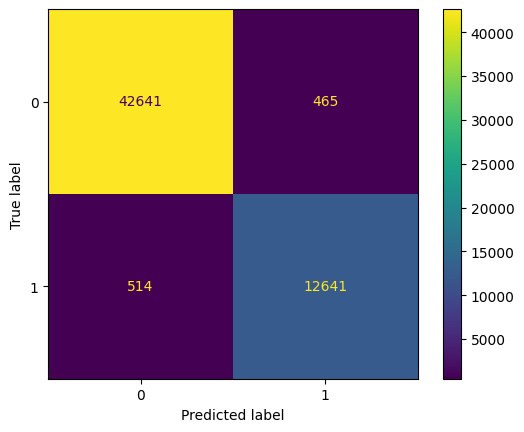

In [ ]:
print_metrics_cv(results_hp_search=best_tree_balanced_und, model_name='DecisionTreeClassifier_UN')

print("Testing:")
test_pred_dt_under = best_tree_balanced_und.predict(X_sc_test)
print_report_score(y_test,test_pred_dt_under)
print_confusion_matrix(y_test,test_pred_dt_under,best_tree_balanced_und)

## SVM

In [35]:
params = {
  "linear_rbf_sigmoid": {
   "kernel": ['linear', 'rbf','sigmoid'],
   "C":[1e-4,1e1,1e4],
   "gamma" : ['scale', 'auto'],
   "random_state": [42],
   "class_weight":['balanced', None],
    "max_iter": [10000]
  },
  "poly": {
    "kernel": ['poly'],
    "C":[1e-4,1e1,1e4],
    "degree": [2,3,5],
    "gamma" : ['scale', 'auto'],
    "random_state": [42],
    "class_weight":['balanced', None],
    "max_iter": [10000]
  }
    } 

best_svc = do_sklearn_GridSearchCV("SVC",SVC(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,4,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[CV 1/5; 1/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 2/5; 1/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 4/5; 1/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 3/5; 1/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 1/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.525, test=0.526) total time=  29.2s
[CV 5/5; 1/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 1/5; 1/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.507, test=0.518) total time=  29.7s
[CV 1/5; 2/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 2/5; 1/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, 

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 1/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.513, test=0.513) total time=  28.2s
[CV 4/5; 2/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 2/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.565, test=0.560) total time=  48.8s
[CV 5/5; 2/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 3/5; 2/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.521, test=0.522) total time=  51.1s
[CV 1/5; 3/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 1/5; 2/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.3

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 2/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.523, test=0.520) total time=  47.7s
[CV 3/5; 3/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 3/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.642, test=0.644) total time=  52.6s
[CV 4/5; 3/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 1/5; 3/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.621, test=0.618) total time=  55.6s
[CV 5/5; 3/72] START C=0.0001, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 5/5; 2/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.3

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 3/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.638, test=0.640) total time=  55.8s
[CV 2/5; 4/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 1/5; 4/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.507, test=0.518) total time=  24.9s
[CV 3/5; 4/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 4/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.513, test=0.508) total time=  24.8s
[CV 4/5; 4/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 4/5; 3/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.617, test=0.612) total time=  53.3s
[CV 5/5; 4/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 5/5; 3/72] END C=0.0001, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 4/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.505, test=0.504) total time=  27.0s
[CV 3/5; 5/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 4/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.513, test=0.513) total time=  26.4s
[CV 4/5; 5/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 5/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.477, test=0.472) total time=  46.5s
[CV 5/5; 5/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 1/5; 5/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.537, test=0.536) total time=  49.7s
[CV 1/5; 6/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 5/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.494, test=0.500) total time=  48.6s
[CV 2/5; 6/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 5/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.534, test=0.530) total time=  49.9s
[CV 3/5; 6/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 6/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.624, test=0.620) total time=  52.9s
[CV 4/5; 6/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 2/5; 6/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.641, test=0.644) total time=  50.3s
[CV 5/5; 6/72] START C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 5/5; 5/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, t

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 6/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.641, test=0.643) total time=  52.6s
[CV 2/5; 7/72] START C=0.0001, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 7/72] END C=0.0001, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.455, test=0.462) total time=  34.5s
[CV 3/5; 7/72] START C=0.0001, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 4/5; 6/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.640, test=0.635) total time=  52.5s
[CV 4/5; 7/72] START C=0.0001, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 2/5; 7/72] END C=0.0001, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) p

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 6/72] END C=0.0001, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.635, test=0.640) total time=  53.7s
[CV 1/5; 8/72] START C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 7/72] END C=0.0001, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=0.998, test=0.998) roc_auc: (train=0.474, test=0.474) total time=  34.7s
[CV 2/5; 8/72] START C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 7/72] END C=0.0001, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=0.999) roc_auc: (train=0.521, test=0.518) total time=  35.2s
[CV 3/5; 8/72] START C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 7/72] END C=0.0001, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.567, test=0.572) total time=  34.6s
[CV 4/5; 8/72] START C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 8/72] END C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.490, test=0.493) f1: (train=0.352, test=0.353) precision: (train=0.251, test=0.252) recall: (train=0.592, test=0.592) roc_auc: (train=0.537, test=0.540) total time= 1.2min
[CV 5/5; 8/72] START C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 2/5; 8/72] END C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.422, test=0.416) f1: (train=0.361, test=0.354) precision: (train=0.244, test=0.239) recall: (train=0.699, test=0.685) roc_auc: (train=0.527, test=0.514) total time= 1.2min
[CV 1/5; 9/72] START C=0.0001, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 8/72] END C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.441, test=0.438) f1: (train=0.322, test=0.316) precision: (train=0.225, test=0.221) recall: (train=0.568, test=0.554) roc_auc: (train=0.497, test=0.491) total time= 1.2min
[CV 2/5; 9/72] START C=0.0001, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 4/5; 8/72] END C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.421, test=0.421) f1: (train=0.354, test=0.355) precision: (train=0.239, test=0.240) recall: (train=0.678, test=0.680) roc_auc: (train=0.528, test=0.523) total time= 1.2min
[CV 3/5; 9/72] START C=0.0001, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 9/72] END C=0.0001, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.250, test=0.252) f1: (train=0.373, test=0.374) precision: (train=0.232, test=0.233) recall: (train=0.956, test=0.957) roc_auc: (train=0.516, test=0.528) total time= 1.5min
[CV 4/5; 9/72] START C=0.0001, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 5/5; 8/72] END C=0.0001, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.471, test=0.468) f1: (train=0.364, test=0.359) precision: (train=0.253, test=0.250) recall: (train=0.646, test=0.638) roc_auc: (train=0.539, test=0.533) total time= 1.3min
[CV 5/5; 9/72] START C=0.0001, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 2/5; 9/72] END C=0.0001, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.337, test=0.336) f1: (train=0.383, test=0.379) prec

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 10/72] END C=0.0001, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.455, test=0.462) total time=  33.3s
[CV 3/5; 10/72] START C=0.0001, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 2/5; 10/72] END C=0.0001, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=0.999, test=0.999) roc_auc: (train=0.496, test=0.488) total time=  33.5s
[CV 4/5; 10/72] START C=0.0001, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 10/72] END C=0.0001, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=0.998, test=0.998) roc_auc: (train=0.474, test=0.474) total time=  34.3s
[CV 5/5; 10/72] START C=0.0001, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 4/5; 10/72] END C=0.0001, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=0.999) roc_auc: (train=0.521, test=0.518) total time=  34.2s
[CV 1/5; 11/72] START C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 9/72] END C=0.0001, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.252, test=0.251) f1: (train=0.373, test=0.373) precision: (train=0.232, test=0.232) recall: (train=0.951, test=0.951) roc_auc: (train=0.523, test=0.517) total time= 1.4min
[CV 2/5; 11/72] START C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 9/72] END C=0.0001, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.249, test=0.250) f1: (train=0.372, test=0.373) precision: (train=0.231, test=0.232) recall: (train=0.952, test=0.955) roc_auc: (train=0.503, test=0.505) total time= 1.4min
[CV 3/5; 11/72] START C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 10/72] END C=0.0001, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.567, test=0.572) total time=  34.6s
[CV 4/5; 11/72] START C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 11/72] END C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.603, test=0.604) f1: (train=0.341, test=0.343) precision: (train=0.279, test=0.280) recall: (train=0.440, test=0.441) roc_auc: (train=0.560, test=0.563) total time= 1.2min
[CV 5/5; 11/72] START C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 2/5; 11/72] END C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.347, test=0.343) f1: (train=0.349, test=0.344) precision: (train=0.227, test=0.224) recall: (train=0.747, test=0.736) roc_auc: (train=0.503, test=0.494) total time= 1.2min
[CV 1/5; 12/72] START C=0.0001, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 3/5; 11/72] END C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.469, test=0.473) f1: (train=0.314, test=0.320) precision: (trai

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 11/72] END C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.506, test=0.502) f1: (train=0.336, test=0.334) precision: (train=0.245, test=0.243) recall: (train=0.534, test=0.534) roc_auc: (train=0.526, test=0.518) total time= 1.2min
[CV 3/5; 12/72] START C=0.0001, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 12/72] END C=0.0001, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.277, test=0.283) f1: (train=0.372, test=0.375) precision: (train=0.233, test=0.235) recall: (train=0.914, test=0.920) roc_auc: (train=0.528, test=0.539) total time= 1.5min
[CV 4/5; 12/72] START C=0.0001, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 2/5; 12/72] END C=0.0001, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.246, test=0.245) f1: (train=0.377, test=0.375) precision: (train=0.234, test=0.233) recall: (train=0.976, test=0.969) roc_auc: (train=0.575, test=0.566) total time= 1.4min
[CV 5/5; 12/72] START C=0.0001, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 5/5; 11/72] END C=0.0001, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.383, test=0.381) f1: (train=0.323, test=0.321) prec

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 12/72] END C=0.0001, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.305, test=0.306) f1: (train=0.381, test=0.382) precision: (train=0.241, test=0.241) recall: (train=0.914, test=0.916) roc_auc: (train=0.573, test=0.568) total time= 1.4min
[CV 2/5; 13/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 1/5; 13/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.310, test=0.313) f1: (train=0.335, test=0.340) precision: (train=0.216, test=0.219) recall: (train=0.743, test=0.756) roc_auc: (train=0.449, test=0.450) total time=  17.2s
[CV 3/5; 13/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 13/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.471, test=0.473) f1: (train=0.358, test=0.359) precision: (train=0.250, test=0.251) recall: (train=0.631, test=0.631) roc_auc: (train=0.552, test=0.551) total time=  17.7s
[CV 4/5; 13/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 3/5; 13/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.512, test=0.516) f1: (train=0.373, test=0.374) precision: (train=0.267, test=0.268) recall: (train=0.621, test=0.619) roc_auc: (train=0.561, test=0.565) total time=  17.5s
[CV 5/5; 13/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 13/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.611, test=0.606) f1: (train=0.379, test=0.370) precision: (train=0.302, test=0.296) recall: (train=0.507, test=0.495) roc_auc: (train=0.605, test=0.599) total time=  16.8s
[CV 1/5; 14/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 13/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.667, test=0.671) f1: (train=0.352, test=0.365) precision: (train=0.323, test=0.333) recall: (train=0.386, test=0.403) roc_auc: (train=0.645, test=0.646) total time=  16.9s
[CV 2/5; 14/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 12/72] END C=0.0001, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.271, test=0.268) f1: (train=0.372, test=0.370) precision: (train=0.233, test=0.232) recall: (train=0.924, test=0.919) roc_auc: (train=0.556, test=0.544) total time= 1.4min
[CV 3/5; 14/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 12/72] END C=0.0001, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.252, test=0.252) f1: (train=0.371, test=0.372) precision: (train=0.231, test=0.231) recall: (train=0.944, test=0.946) roc_auc: (train=0.504, test=0.506) total time= 1.4min
[CV 4/5; 14/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 14/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.505, test=0.508) f1: (train=0.334, test=0.332) precision: (train=0.244, test=0.243) recall: (train=0.531, test=0.522) roc_auc: (train=0.516, test=0.516) total time=  44.8s
[CV 5/5; 14/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 1/5; 14/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.369, test=0.371) f1: (train=0.363, test=0.366) precision: (train=0.238, test=0.239) recall: (train=0.768, test=0.776) roc_auc: (train=0.506, test=0.508) total time=  46.3s
[CV 1/5; 15/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 14/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.519, test=0.525) f1: (train=0.310, test=0.314) precision: (train=0.233, test=0.237) recall: (train=0.463, test=0.466) roc_auc: (train=0.495, test=0.498) total time=  44.7s
[CV 2/5; 15/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 4/5; 14/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.527, test=0.524) f1: (train=0.270, test=0.267) precision: (train=0.211, test=0.209) recall: (train=0.374, test=0.371) roc_auc: (train=0.457, test=0.451) total time=  44.9s
[CV 3/5; 15/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 1/5; 15/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.425, test=0.430) f1: (train=0.355, test=

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 14/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.503, test=0.503) f1: (train=0.299, test=0.298) precision: (train=0.223, test=0.223) recall: (train=0.453, test=0.452) roc_auc: (train=0.480, test=0.482) total time=  46.0s
[CV 5/5; 15/72] START C=10.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 15/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.545, test=0.545) f1: (train=0.381, test=0.379) precision: (train=0.280, test=0.278) recall: (train=0.600, test=0.593) roc_auc: (train=0.587, test=0.585) total time=  50.5s
[CV 1/5; 16/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 3/5; 15/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.566, test=0.571) f1: (train=0.421, test=0.423) precision: (train=0.306, test=0.309) recall: (train=0.675, test=0.672) roc_auc: (train=0.630, test=0.629) total time=  49.5s
[CV 2/5; 16/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 15/72] END C=10.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.388, test=0.382) f1: (train=0.376, test=0.374) precision: (train=0.247, test=0.245) recall: (train=0.790, test=0.790) roc_auc: (train=0.557, test=0.552) total time=  47.9s
[CV 3/5; 16/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 1/5; 16/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.310, test=0.313) f1: (train=0.335, test=0.340) precision: (train=0.216, test=0.219) recall: (train=0.743, test=0.756) roc_auc: (train=0.449, test=0.450) total time=  15.9s
[CV 4/5; 16/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 2/5; 16/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.471, test=0.473) f1: (train=0.358, test=

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 16/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.512, test=0.516) f1: (train=0.373, test=0.374) precision: (train=0.267, test=0.268) recall: (train=0.621, test=0.619) roc_auc: (train=0.561, test=0.565) total time=  17.3s
[CV 1/5; 17/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 4/5; 16/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.611, test=0.606) f1: (train=0.379, test=0.370) precision: (train=0.302, test=0.296) recall: (train=0.507, test=0.495) roc_auc: (train=0.605, test=0.599) total time=  17.0s
[CV 2/5; 17/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 16/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.667, test=0.671) f1: (train=0.352, test=0.365) p

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 17/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.529, test=0.532) f1: (train=0.296, test=0.296) precision: (train=0.227, test=0.228) recall: (train=0.423, test=0.421) roc_auc: (train=0.483, test=0.482) total time=  46.8s
[CV 5/5; 17/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 3/5; 17/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.478, test=0.485) f1: (train=0.279, test=0.284) precision: (train=0.206, test=0.210) recall: (train=0.432, test=0.436) roc_auc: (train=0.450, test=0.451) total time=  46.4s
[CV 1/5; 18/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 1/5; 17/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.388, test=0.394) f1: (train=0.328, test=0.329) precis

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 18/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.406, test=0.412) f1: (train=0.353, test=0.358) precision: (train=0.237, test=0.240) recall: (train=0.692, test=0.700) roc_auc: (train=0.525, test=0.531) total time=  49.2s
[CV 4/5; 18/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 2/5; 18/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.545, test=0.545) f1: (train=0.382, test=0.381) precision: (train=0.280, test=0.279) recall: (train=0.602, test=0.597) roc_auc: (train=0.588, test=0.585) total time=  51.3s
[CV 5/5; 18/72] START C=10.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 3/5; 18/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.563, test=0.567) f1: (train=0.422, te

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 17/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.495, test=0.496) f1: (train=0.271, test=0.271) precision: (train=0.205, test=0.204) recall: (train=0.402, test=0.400) roc_auc: (train=0.447, test=0.446) total time=  45.4s
[CV 2/5; 19/72] START C=10.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 1/5; 19/72] END C=10.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.274, test=0.275) f1: (train=0.350, test=0.351) precision: (train=0.221, test=0.222) recall: (train=0.836, test=0.838) roc_auc: (train=0.397, test=0.406) total time=  15.3s
[CV 3/5; 19/72] START C=10.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 19/72] END C=10.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.317, test=0.317) f1: (train=0.343, test=0.343) precision: (train=0.221, test=0.221) recall: (train=0.761, test=0.761) roc_auc: (train=0.465, test=0.464) total time=  15.3s
[CV 4/5; 19/72] START C=10.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 3/5; 19/72] END C=10.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.613, test=0.615) f1: (train=0.352, test=0.353) precision: (train=0.289, test=0.290) recall: (train=0.449, test=0.449) roc_auc: (train=0.590, test=0.590) total time=  15.2s
[CV 5/5; 19/72] START C=10.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 19/72] END C=10.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.253, test=0.255) f1: (train=0.341, test=0.344) precision: (train=0.215, test=0.216) recall: (train=0.829, test=0.834) roc_auc: (train=0.340, test=0.345) total time=  15.1s
[CV 1/5; 20/72] START C=10.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 19/72] END C=10.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.325, test=0.326) f1: (train=0.329, test=0.328) precision: (train=0.215, test=0.214) recall: (train=0.709, test=0.703) roc_auc: (train=0.458, test=0.454) total time=  15.8s


/Users/lau/Library/Python/3.11/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5; 20/72] START C=10.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 4/5; 18/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.403, test=0.398) f1: (train=0.376, test=0.374) precision: (train=0.249, test=0.247) recall: (train=0.769, test=0.768) roc_auc: (train=0.557, test=0.552) total time=  48.3s
[CV 3/5; 20/72] START C=10.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 18/72] END C=10.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.442, test=0.449) f1: (train=0.359, test=0.365) precision: (train=0.245, test=0.250) recall: (train=0.668, test=0.678) roc_auc: (train=0.534, test=0.543) total time=  49.6s
[CV 4/5; 20/72] START C=10.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 20/72] END C=10.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.512, test=0.514) f1: (train=0.326, test=0.330) precision: (train=0.241, test=0.243) recall: (train=0.506, test=0.513) roc_auc: (train=0.505, test=0.509) total time= 1.1min
[CV 5/5; 20/72] START C=10.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 2/5; 20/72] END C=10.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.488, test=0.492) f1: (train=0.355, test=0.357) precision: (train=0.252, test=0.253) recall: (train=0.604, test=0.601) roc_auc: (train=0.540, test=0.539) total time= 1.1min
[CV 1/5; 21/72] START C=10.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 3/5; 20/72] END C=10.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.607, test=0.605) f1: (train=0.345, test=0.346) precision: (train=0.2

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 20/72] END C=10.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.479, test=0.474) f1: (train=0.358, test=0.349) precision: (train=0.251, test=0.246) recall: (train=0.621, test=0.604) roc_auc: (train=0.542, test=0.529) total time= 1.1min
[CV 3/5; 21/72] START C=10.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 21/72] END C=10.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.444, test=0.452) f1: (train=0.332, test=0.339) precision: (train=0.231, test=0.236) recall: (train=0.590, test=0.601) roc_auc: (train=0.522, test=0.531) total time= 1.3min
[CV 4/5; 21/72] START C=10.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 2/5; 21/72] END C=10.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.467, test=0.462) f1: (train=0.339, test=0.334) precision: (train=0.239, test=0.235) recall: (train=0.585, test=0.576) roc_auc: (train=0.530, test=0.521) total time= 1.3min
[CV 5/5; 21/72] START C=10.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 3/5; 21/72] END C=10.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.539, test=0.541) f1: (train=0.384, test=0.381) preci

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 22/72] END C=10.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.274, test=0.275) f1: (train=0.350, test=0.351) precision: (train=0.221, test=0.222) recall: (train=0.836, test=0.838) roc_auc: (train=0.397, test=0.406) total time=  15.1s
[CV 3/5; 22/72] START C=10.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 22/72] END C=10.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.317, test=0.317) f1: (train=0.343, test=0.343) precision: (train=0.221, test=0.221) recall: (train=0.761, test=0.761) roc_auc: (train=0.465, test=0.464) total time=  15.3s
[CV 4/5; 22/72] START C=10.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 22/72] END C=10.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.613, test=0.615) f1: (train=0.352, test=0.353) precision: (train=0.289, test=0.290) recall: (train=0.449, test=0.449) roc_auc: (train=0.590, test=0.590) total time=  15.2s
[CV 5/5; 22/72] START C=10.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 4/5; 22/72] END C=10.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.253, test=0.255) f1: (train=0.341, test=0.344) precision: (train=0.215, test=0.216) recall: (train=0.829, test=0.834) roc_auc: (train=0.340, test=0.345) total time=  15.3s
[CV 1/5; 23/72] START C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 22/72] END C=10.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.325, test=0.326) f1: (train=0.329, test=0.328) precision: (train=0.215, test=0.214) recall: (train=0.709, test=0.703) roc_auc: (train=0.458, test=0.454) total time=  15.6s
[CV 2/5; 23/72] START C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 21/72] END C=10.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.466, test=0.458) f1: (train=0.338, test=0.333) precision: (train=0.238, test=0.234) recall: (train=0.584, test=0.578) roc_auc: (train=0.533, test=0.526) total time= 1.3min
[CV 3/5; 23/72] START C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 21/72] END C=10.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.448, test=0.451) f1: (train=0.336, test=0.336) precision: (train=0.234, test=0.234) recall: (train=0.598, test=0.595) roc_auc: (train=0.526, test=0.529) total time= 1.3min
[CV 4/5; 23/72] START C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 23/72] END C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.428, test=0.425) f1: (train=0.303, test=0.302) precision: (train=0.212, test=0.211) recall: (train=0.531, test=0.531) roc_auc: (train=0.459, test=0.460) total time= 1.1min
[CV 5/5; 23/72] START C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 2/5; 23/72] END C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.520, test=0.517) f1: (train=0.326, test=0.324) precision: (train=0.243, test=0.241) recall: (train=0.497, test=0.494) roc_auc: (train=0.519, test=0.517) total time= 1.1min
[CV 1/5; 24/72] START C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 23/72] END C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.529, test=0.528) f1: (train=0.293, test=0.292) precision: (train=0.226, test=0.225) recall: (train=0.419, test=0.417) roc_auc: (train=0.493, test=0.491) total time= 1.1min
[CV 2/5; 24/72] START C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 4/5; 23/72] END C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.453, test=0.443) f1: (train=0.296, test=0.289) precision: (train=0.212, test=0.206) recall: (train=0.493, test=0.484) roc_auc: (train=0.462, test=0.451) total time= 1.1min
[CV 3/5; 24/72] START C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 24/72] END C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.446, test=0.454) f1: (train=0.331, test=0.338) precision: (train=0.231, test=0.236) recall: (train=0.586, test=0.597) roc_auc: (train=0.522, test=0.531) total time= 1.3min
[CV 4/5; 24/72] START C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 5/5; 23/72] END C=10.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.660, test=0.666) f1: (train=0.310, test=0.315) precision: (train=0.295, test=0.302) recall: (train=0.327, test=0.329) roc_auc: (train=0.577, test=0.584) total time= 1.1min
[CV 5/5; 24/72] START C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 24/72] END C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.458, test=0.454) f1: (train=0.338, test=0.333) precision: (train=0.236, test=0.233) recall: (train=0.590, test=0.583) roc_auc: (train=0.529, test=0.520) total time= 1.3min
[CV 1/5; 25/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 24/72] END C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.585, test=0.585) f1: (train=0.373, test=0.368) precision: (train=0.289, test=0.286) recall: (train=0.529, test=0.517) roc_auc: (train=0.566, test=0.562) total time= 1.3min
[CV 2/5; 25/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 1/5; 25/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.482, test=0.483) f1: (train=0.335, test=0.337) precision: (train=0.239, test=0.241) recall: (train=0.558, test=0.561) roc_auc: (train=0.527, test=0.522) total time=  11.3s
[CV 3/5; 25/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 25/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.437, test=0.440) f1: (train=0.350, test=0.352) precision: (train=0.240, test=0.241) recall: (train=0.650, test=0.650) roc_auc: (train=0.517, test=0.521) total time=  11.6s
[CV 4/5; 25/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 3/5; 25/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.485, test=0.491) f1: (train=0.370, test=0.374) precision: (train=0.259, test=0.262) recall: (train=0.646, test=0.650) roc_auc: (train=0.552, test=0.559) total time=  11.8s
[CV 5/5; 25/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 25/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.360, test=0.358) f1: (train=0.349, test=0.347) precision: (train=0.229, test=0.228) recall: (train=0.732, test=0.731) roc_auc: (train=0.504, test=0.503) total time=  11.4s
[CV 1/5; 26/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 25/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.553, test=0.555) f1: (train=0.358, test=0.365) precision: (train=0.270, test=0.274) recall: (train=0.532, test=0.547) roc_auc: (train=0.569, test=0.575) total time=  11.4s
[CV 2/5; 26/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 24/72] END C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.468, test=0.460) f1: (train=0.340, test=0.335) precision: (train=0.239, test=0.235) recall: (train=0.585, test=0.581) roc_auc: (train=0.534, test=0.527) total time= 1.3min
[CV 3/5; 26/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 24/72] END C=10.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.460, test=0.463) f1: (train=0.336, test=0.337) precision: (train=0.236, test=0.237) recall: (train=0.584, test=0.582) roc_auc: (train=0.527, test=0.530) total time= 1.3min
[CV 4/5; 26/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 26/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.596, test=0.595) f1: (train=0.277, test=0.277) precision: (train=0.238, test=0.238) recall: (train=0.331, test=0.333) roc_auc: (train=0.513, test=0.511) total time=  45.9s
[CV 5/5; 26/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 2/5; 26/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.499, test=0.499) f1: (train=0.279, test=0.277) precision: (train=0.210, test=0.209) recall: (train=0.414, test=0.412) roc_auc: (train=0.469, test=0.469) total time=  46.4s
[CV 1/5; 27/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 26/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.582, test=0.581) f1: (train=0.331, test=0.325) precision: (train=0.265, test=0.261) recall: (train=0.443, test=0.431) roc_auc: (train=0.550, test=0.542) total time=  42.9s
[CV 2/5; 27/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 4/5; 26/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.575, test=0.573) f1: (train=0.267, test=0.264) precision: (train=0.223, test=0.221) recall: (train=0.330, test=0.327) roc_auc: (train=0.477, test=0.474) total time=  44.1s
[CV 3/5; 27/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 27/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.439, test=0.444) f1: (train=0.355, test=0.359) precision: (train=0.243, test=0.246) recall: (train=0.661, test=0.665) roc_auc: (train=0.529, test=0.535) total time=  47.3s
[CV 4/5; 27/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 5/5; 26/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.561, test=0.566) f1: (train=0.233, test=0.236) precision: (train=0.197, test=0.201) recall: (train=0.285, test=0.286) roc_auc: (train=0.448, test=0.447) total time=  43.8s
[CV 5/5; 27/72] START C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 27/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.547, test=0.547) f1: (train=0.382, test=0.379) precision: (train=0.280, test=0.279) recall: (train=0.598, test=0.591) roc_auc: (train=0.588, test=0.585) total time=  53.5s
[CV 1/5; 28/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 27/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.562, test=0.566) f1: (train=0.418, test=0.420) precision: (train=0.303, test=0.305) recall: (train=0.673, test=0.670) roc_auc: (train=0.628, test=0.627) total time=  52.6s
[CV 2/5; 28/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 1/5; 28/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.482, test=0.483) f1: (train=0.335, test=0.337) precision: (train=0.239, test=0.241) recall: (train=0.558, test=0.561) roc_auc: (train=0.527, test=0.522) total time=  11.4s
[CV 3/5; 28/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 28/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.437, test=0.440) f1: (train=0.350, test=0.352) precision: (train=0.240, test=0.241) recall: (train=0.650, test=0.650) roc_auc: (train=0.517, test=0.521) total time=  11.5s
[CV 4/5; 28/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 3/5; 28/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.485, test=0.491) f1: (train=0.370, test=0.374) precision: (train=0.259, test=0.262) recall: (train=0.646, test=0.650) roc_auc: (train=0.552, test=0.559) total time=  11.5s
[CV 5/5; 28/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 27/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.389, test=0.383) f1: (train=0.376, test=0.374) precision: (train=0.247, test=0.245) recall: (train=0.788, test=0.790) roc_auc: (train=0.557, test=0.553) total time=  47.9s
[CV 1/5; 29/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 28/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.360, test=0.358) f1: (train=0.349, test=0.347) precision: (train=0.229, test=0.228) recall: (train=0.732, test=0.731) roc_auc: (train=0.504, test=0.503) total time=  11.3s
[CV 2/5; 29/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 28/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.553, test=0.555) f1: (train=0.358, test=0.365) precision: (train=0.270, test=0.274) recall: (train=0.532, test=0.547) roc_auc: (train=0.569, test=0.575) total time=  11.6s
[CV 3/5; 29/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 27/72] END C=10000.0, class_weight=balanced, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.444, test=0.452) f1: (train=0.3

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 29/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.572, test=0.572) f1: (train=0.283, test=0.280) precision: (train=0.233, test=0.231) recall: (train=0.362, test=0.357) roc_auc: (train=0.512, test=0.513) total time=  45.4s
[CV 5/5; 29/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 1/5; 29/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.598, test=0.594) f1: (train=0.340, test=0.335) precision: (train=0.276, test=0.272) recall: (train=0.443, test=0.437) roc_auc: (train=0.566, test=0.564) total time=  46.6s
[CV 1/5; 30/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 3/5; 29/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.544, test=0.543) f1: (train=0.302, tes

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 30/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.431, test=0.435) f1: (train=0.355, test=0.358) precision: (train=0.242, test=0.244) recall: (train=0.671, test=0.675) roc_auc: (train=0.529, test=0.535) total time=  48.7s
[CV 4/5; 30/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 5/5; 29/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.641, test=0.641) f1: (train=0.362, test=0.362) precision: (train=0.310, test=0.310) recall: (train=0.436, test=0.435) roc_auc: (train=0.611, test=0.611) total time=  43.6s
[CV 5/5; 30/72] START C=10000.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 2/5; 30/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.548, test=0.548) f1: (trai

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 31/72] END C=10000.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.380, test=0.383) f1: (train=0.354, test=0.355) precision: (train=0.234, test=0.235) recall: (train=0.728, test=0.727) roc_auc: (train=0.515, test=0.517) total time=  12.0s
[CV 3/5; 31/72] START C=10000.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 2/5; 31/72] END C=10000.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.504, test=0.501) f1: (train=0.322, test=0.319) precision: (train=0.237, test=0.234) recall: (train=0.504, test=0.499) roc_auc: (train=0.500, test=0.498) total time=  11.8s


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 31/72] START C=10000.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 31/72] END C=10000.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.322, test=0.318) f1: (train=0.344, test=0.338) precision: (train=0.222, test=0.219) recall: (train=0.760, test=0.747) roc_auc: (train=0.461, test=0.452) total time=  12.0s
[CV 5/5; 31/72] START C=10000.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42
[CV 4/5; 31/72] END C=10000.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.309, test=0.307) f1: (train=0.335, test=0.332) precision: (train=0.216, test=0.214) recall: (train=0.744, test=0.737) roc_auc: (train=0.417, test=0.418) total time=  11.8s
[CV 1/5; 32/72] START C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 31/72] END C=10000.0, class_weight=None, gamma=scale, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.418, test=0.416) f1: (train=0.317, test=0.315) precision: (train=0.219, test=0.217) recall: (train=0.578, test=0.575) roc_auc: (train=0.466, test=0.459) total time=  11.3s
[CV 2/5; 32/72] START C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 30/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.387, test=0.381) f1: (train=0.376, test=0.374) precision: (train=0.247, test=0.245) recall: (train=0.790, test=0.791) roc_auc: (train=0.556, test=0.552) total time=  47.9s
[CV 3/5; 32/72] START C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 30/72] END C=10000.0, class_weight=balanced, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.449, test=0.455) f1: (train=0.360, test=0.366) precision: (train=0.247, test=0.251) recall: (train=0.662, test=0.672) roc_auc: (train=0.535, test=0.545) total time=  48.7s
[CV 4/5; 32/72] START C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 32/72] END C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.631, test=0.635) f1: (train=0.310, test=0.308) precision: (train=0.275, test=0.276) recall: (train=0.354, test=0.348) roc_auc: (train=0.539, test=0.541) total time=  45.6s
[CV 5/5; 32/72] START C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42
[CV 2/5; 32/72] END C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.539, test=0.538) f1: (train=0.287, test=0.288) precision: (train=0.225, test=0.225) recall: (train=0.397, test=0.398) roc_auc: (train=0.484, test=0.484) total time=  45.7s
[CV 1/5; 33/72] START C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 32/72] END C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.476, test=0.479) f1: (train=0.351, test=0.357) precision: (train=0.247, test=0.251) recall: (train=0.606, test=0.619) roc_auc: (train=0.524, test=0.532) total time=  43.9s
[CV 2/5; 33/72] START C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 4/5; 32/72] END C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.507, test=0.503) f1: (train=0.242, test=0.242) precision: (train=0.189, test=0.188) recall: (train=0.337, test=0.340) roc_auc: (train=0.422, test=0.415) total time=  44.6s
[CV 3/5; 33/72] START C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 32/72] END C=10000.0, class_weight=None, gamma=scale, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.583, test=0.588) f1: (train=0.226, test=0.232) precision: (train=0.200, test=0.206) recall: (train=0.261, test=0.267) roc_auc: (train=0.435, test=0.436) total time=  44.5s
[CV 4/5; 33/72] START C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 33/72] END C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.445, test=0.452) f1: (train=0.333, test=0.339) precision: (train=0.231, test=0.236) recall: (train=0.592, test=0.600) roc_auc: (train=0.523, test=0.532) total time= 1.3min
[CV 5/5; 33/72] START C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42
[CV 2/5; 33/72] END C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.483, test=0.475) f1: (train=0.341, test=0.334) precision: (train=0.243, test=0.237) recall: (train=0.571, test=0.562) roc_auc: (train=0.529, test=0.520) total time= 1.3min
[CV 1/5; 34/72] START C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 33/72] END C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.596, test=0.595) f1: (train=0.370, test=0.365) precision: (train=0.291, test=0.288) recall: (train=0.508, test=0.496) roc_auc: (train=0.569, test=0.565) total time= 1.3min
[CV 2/5; 34/72] START C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 1/5; 34/72] END C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.380, test=0.383) f1: (train=0.354, test=0.355) precision: (train=0.234, test=0.235) recall: (train=0.728, test=0.727) roc_auc: (train=0.515, test=0.517) total time=  12.7s
[CV 3/5; 34/72] START C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 34/72] END C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.504, test=0.501) f1: (train=0.322, test=0.319) precision: (train=0.237, test=0.234) recall: (train=0.504, test=0.499) roc_auc: (train=0.500, test=0.498) total time=  13.2s
[CV 4/5; 34/72] START C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42
[CV 3/5; 34/72] END C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.322, test=0.318) f1: (train=0.344, test=0.338) precision: (train=0.222, test=0.219) recall: (train=0.760, test=0.747) roc_auc: (train=0.461, test=0.452) total time=  13.2s
[CV 5/5; 34/72] START C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 34/72] END C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.309, test=0.307) f1: (train=0.335, test=0.332) precision: (train=0.216, test=0.214) recall: (train=0.744, test=0.737) roc_auc: (train=0.417, test=0.418) total time=  12.1s
[CV 1/5; 35/72] START C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 5/5; 34/72] END C=10000.0, class_weight=None, gamma=auto, kernel=linear, max_iter=10000, random_state=42; accuracy: (train=0.418, test=0.416) f1: (train=0.317, test=0.315) precision: (train=0.219, test=0.217) recall: (train=0.578, test=0.575) roc_auc: (train=0.466, test=0.459) total time=  11.9s
[CV 2/5; 35/72] START C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 33/72] END C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.455, test=0.448) f1: (train=0.338, test=0.333) precision: (train=0.236, test=0.232) recall: (train=0.595, test=0.589) roc_auc: (train=0.533, test=0.526) total time= 1.3min
[CV 3/5; 35/72] START C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 33/72] END C=10000.0, class_weight=None, gamma=scale, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.450, test=0.453) f1: (train=0.337, test=0.336) precision: (train=0.234, test=0.235) recall: (train=0.597, test=0.593) roc_auc: (train=0.528, test=0.530) total time= 1.4min
[CV 4/5; 35/72] START C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 35/72] END C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.512, test=0.512) f1: (train=0.281, test=0.283) precision: (train=0.214, test=0.215) recall: (train=0.408, test=0.412) roc_auc: (train=0.468, test=0.468) total time=  48.3s
[CV 5/5; 35/72] START C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42
[CV 2/5; 35/72] END C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.604, test=0.598) f1: (train=0.253, test=0.246) precision: (train=0.226, test=0.219) recall: (train=0.286, test=0.281) roc_auc: (train=0.503, test=0.496) total time=  48.7s
[CV 1/5; 36/72] START C=10000.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 3/5; 35/72] END C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.615, test=0.612) f1: (train=0.337, test=0.331) precision: 

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 35/72] END C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.581, test=0.575) f1: (train=0.284, test=0.282) precision: (train=0.237, test=0.233) recall: (train=0.356, test=0.356) roc_auc: (train=0.498, test=0.490) total time=  46.4s
[CV 3/5; 36/72] START C=10000.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 5/5; 35/72] END C=10000.0, class_weight=None, gamma=auto, kernel=rbf, max_iter=10000, random_state=42; accuracy: (train=0.597, test=0.599) f1: (train=0.303, test=0.302) precision: (train=0.254, test=0.254) recall: (train=0.374, test=0.371) roc_auc: (train=0.529, test=0.526) total time=  44.2s
[CV 4/5; 36/72] START C=10000.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 36/72] END C=10000.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.444, test=0.452) f1: (train=0.333, test=0.340) precision: (train=0.232, test=0.237) recall: (train=0.594, test=0.603) roc_auc: (train=0.523, test=0.532) total time= 1.3min
[CV 5/5; 36/72] START C=10000.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42
[CV 2/5; 36/72] END C=10000.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.470, test=0.464) f1: (train=0.343, test=0.338) precision: (train=0.242, test=0.238) recall: (train=0.592, test=0.585) roc_auc: (train=0.530, test=0.521) total time= 1.3min
[CV 1/5; 37/72] START C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 37/72] END C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.496, test=0.497) total time=  24.2s
[CV 2/5; 37/72] START C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 36/72] END C=10000.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.593, test=0.591) f1: (train=0.372, test=0.365) precision: (train=0.291, test=0.287) recall: (train=0.515, test=0.504) roc_auc: (train=0.568, test=0.564) total time= 1.3min
[CV 3/5; 37/72] START C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 36/72] END C=10000.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.450, test=0.444) f1: (train=0.339, test=0.334) precision: (train=0.236, test=0.232) recall: (train=0.602, test=0.596) roc_auc: (train=0.532, test=0.525) total time= 1.3min
[CV 4/5; 37/72] START C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 37/72] END C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.509, test=0.506) total time=  23.7s
[CV 5/5; 37/72] START C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 37/72] END C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.519, test=0.520) total time=  22.6s
[CV 1/5; 38/72] START C=0.0001, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 37/72] END C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.539, test=0.537) total time=  24.2s
[CV 2/5; 38/72] START C=0.0001, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 37/72] END C=0.0001, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.509, test=0.509) total time=  25.2s
[CV 3/5; 38/72] START C=0.0001, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 36/72] END C=10000.0, class_weight=None, gamma=auto, kernel=sigmoid, max_iter=10000, random_state=42; accuracy: (train=0.

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 38/72] END C=0.0001, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.496, test=0.497) total time=  24.3s
[CV 5/5; 38/72] START C=0.0001, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 38/72] END C=0.0001, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.507, test=0.504) total time=  25.4s
[CV 1/5; 39/72] START C=0.0001, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 38/72] END C=0.0001, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.519, test=0.520) total time=  24.1s
[CV 2/5; 39/72] START C=0.0001, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 38/72] END C=0.0001, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy:

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 38/72] END C=0.0001, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.511, test=0.510) total time=  25.0s
[CV 4/5; 39/72] START C=0.0001, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 39/72] END C=0.0001, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.467, test=0.471) total time=  26.9s
[CV 5/5; 39/72] START C=0.0001, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 39/72] END C=0.0001, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.450, test=0.449) total time=  25.4s
[CV 1/5; 40/72] START C=0.0001, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 39/72] END C=0.0001, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accurac

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 39/72] END C=0.0001, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.466, test=0.461) total time=  25.1s
[CV 3/5; 40/72] START C=0.0001, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 39/72] END C=0.0001, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.469, test=0.471) total time=  25.9s
[CV 4/5; 40/72] START C=0.0001, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 40/72] END C=0.0001, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.445, test=0.449) total time=  26.6s
[CV 5/5; 40/72] START C=0.0001, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 40/72] END C=0.0001, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: 

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 40/72] END C=0.0001, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.465, test=0.463) total time=  24.3s
[CV 2/5; 41/72] START C=0.0001, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 40/72] END C=0.0001, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.461, test=0.455) total time=  25.8s
[CV 3/5; 41/72] START C=0.0001, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 40/72] END C=0.0001, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.476, test=0.476) total time=  26.3s
[CV 4/5; 41/72] START C=0.0001, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 41/72] END C=0.0001, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 41/72] END C=0.0001, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.235, test=0.234) f1: (train=0.378, test=0.378) precision: (train=0.234, test=0.233) recall: (train=0.996, test=0.996) roc_auc: (train=0.471, test=0.464) total time=  27.3s
[CV 1/5; 42/72] START C=0.0001, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 41/72] END C=0.0001, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=0.999, test=1.000) roc_auc: (train=0.463, test=0.462) total time=  27.8s
[CV 2/5; 42/72] START C=0.0001, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 41/72] END C=0.0001, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.235, test=0.234) f1: (train=0.378, test=0.378) precision: (train=0.234, test=0.233) recall: (train=0.995, test=0.994) roc_auc: (train=0.476, test=0.471) total time=  28.4s
[CV 3/5; 42/72] START C=0.0001, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 41/72] END C=0.0001, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 42/72] END C=0.0001, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.235, test=0.235) f1: (train=0.378, test=0.379) precision: (train=0.234, test=0.234) recall: (train=0.996, test=0.996) roc_auc: (train=0.466, test=0.465) total time=  26.4s
[CV 5/5; 42/72] START C=0.0001, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 42/72] END C=0.0001, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.235, test=0.234) f1: (train=0.379, test=0.378) precision: (train=0.234, test=0.234) recall: (train=0.997, test=0.997) roc_auc: (train=0.479, test=0.473) total time=  28.2s
[CV 1/5; 43/72] START C=0.0001, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 42/72] END C=0.0001, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=0.998, test=0.998) roc_auc: (train=0.455, test=0.450) total time=  27.6s
[CV 2/5; 43/72] START C=0.0001, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 42/72] END C=0.0001, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 43/72] END C=0.0001, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.459, test=0.464) total time=  36.0s
[CV 5/5; 43/72] START C=0.0001, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 43/72] END C=0.0001, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=0.999, test=0.999) roc_auc: (train=0.468, test=0.463) total time=  36.3s
[CV 1/5; 44/72] START C=0.0001, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 43/72] END C=0.0001, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, tes

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 43/72] END C=0.0001, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.452, test=0.445) total time=  35.9s
[CV 4/5; 44/72] START C=0.0001, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 44/72] END C=0.0001, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.468, test=0.476) total time=  36.4s
[CV 5/5; 44/72] START C=0.0001, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 44/72] END C=0.0001, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 44/72] END C=0.0001, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=0.999) roc_auc: (train=0.525, test=0.522) total time=  36.0s
[CV 3/5; 45/72] START C=0.0001, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 44/72] END C=0.0001, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.473, test=0.474) total time=  36.1s
[CV 4/5; 45/72] START C=0.0001, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 45/72] END C=0.0001, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 45/72] END C=0.0001, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.468, test=0.473) total time=  36.5s
[CV 2/5; 46/72] START C=0.0001, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 45/72] END C=0.0001, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.495, test=0.491) total time=  36.7s
[CV 3/5; 46/72] START C=0.0001, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 45/72] END C=0.0001, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 46/72] END C=0.0001, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.477, test=0.473) total time=  36.5s
[CV 1/5; 47/72] START C=0.0001, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 46/72] END C=0.0001, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.459, test=0.460) total time=  36.5s
[CV 2/5; 47/72] START C=0.0001, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 46/72] END C=0.0001, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 47/72] END C=0.0001, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.478, test=0.476) total time=  39.5s
[CV 5/5; 47/72] START C=0.0001, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 47/72] END C=0.0001, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.487, test=0.476) total time=  39.7s
[CV 1/5; 48/72] START C=0.0001, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 47/72] END C=0.0001, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, tes

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 47/72] END C=0.0001, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.472, test=0.469) total time=  37.7s
[CV 4/5; 48/72] START C=0.0001, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 48/72] END C=0.0001, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.470, test=0.469) total time=  37.8s
[CV 5/5; 48/72] START C=0.0001, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 48/72] END C=0.0001, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 49/72] END C=10.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.276, test=0.278) f1: (train=0.342, test=0.343) precision: (train=0.217, test=0.218) recall: (train=0.806, test=0.808) roc_auc: (train=0.439, test=0.444) total time=  26.2s
[CV 3/5; 49/72] START C=10.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 49/72] END C=10.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.283, test=0.283) f1: (train=0.350, test=0.350) precision: (train=0.222, test=0.222) recall: (train=0.826, test=0.824) roc_auc: (train=0.450, test=0.451) total time=  25.4s
[CV 4/5; 49/72] START C=10.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 48/72] END C=0.0001, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 48/72] END C=0.0001, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.234, test=0.234) f1: (train=0.379, test=0.379) precision: (train=0.234, test=0.234) recall: (train=1.000, test=1.000) roc_auc: (train=0.478, test=0.474) total time=  37.6s
[CV 1/5; 50/72] START C=10.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 49/72] END C=10.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.277, test=0.275) f1: (train=0.344, test=0.342) precision: (train=0.218, test=0.217) recall: (train=0.811, test=0.805) roc_auc: (train=0.446, test=0.445) total time=  25.6s
[CV 2/5; 50/72] START C=10.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 49/72] END C=10.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.273, test=0.274) f1: (train=0.353, test=0.355) precision: (train=0.223, test=0.224) recall: (train=0.847, test=0.854) roc_auc: (train=0.462, test=0.460) total time=  25.8s
[CV 3/5; 50/72] START C=10.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 49/72] END C=10.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 50/72] END C=10.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.268, test=0.269) f1: (train=0.352, test=0.352) precision: (train=0.222, test=0.222) recall: (train=0.850, test=0.849) roc_auc: (train=0.455, test=0.459) total time=  25.5s
[CV 5/5; 50/72] START C=10.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 50/72] END C=10.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.283, test=0.283) f1: (train=0.339, test=0.339) precision: (train=0.216, test=0.216) recall: (train=0.788, test=0.787) roc_auc: (train=0.453, test=0.451) total time=  25.1s
[CV 1/5; 51/72] START C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 50/72] END C=10.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.286, test=0.284) f1: (train=0.342, test=0.338) precision: (train=0.218, test=0.216) recall: (train=0.793, test=0.783) roc_auc: (train=0.453, test=0.453) total time=  25.5s
[CV 2/5; 51/72] START C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 50/72] END C=10.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.277, test=0.280) f1: (train=0.346, test=0.349) precision: (train=0.220, test=0.221) recall: (train=0.820, test=0.824) roc_auc: (train=0.445, test=0.440) total time=  26.3s
[CV 3/5; 51/72] START C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 50/72] END C=10.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.290, test=0.286) f1: (train=0.344, test=0.343) precision: (train=0.219, test=0.219) recall: (train=0.795, test=0.798) roc_auc: (train=0.462, test=0.465) total time=  25.8s
[CV 4/5; 51/72] START C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 51/72] END C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.242) f1: (train=0.375, test=0.376) precision: (train=0.232, test=0.233) recall: (train=0.974, test=0.975) roc_auc: (train=0.499, test=0.498) total time=  16.4s
[CV 5/5; 51/72] START C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 51/72] END C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.244, test=0.245) f1: (train=0.374, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.966, test=0.965) roc_auc: (train=0.525, test=0.519) total time=  17.6s
[CV 1/5; 52/72] START C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 51/72] END C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.243, test=0.242) f1: (train=0.375, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.971, test=0.969) roc_auc: (train=0.509, test=0.509) total time=  18.2s
[CV 2/5; 52/72] START C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 51/72] END C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.242, test=0.242) f1: (train=0.372, test=0.372) precision: (train=0.230, test=0.230) recall: (train=0.958, test=0.959) roc_auc: (train=0.502, test=0.494) total time=  17.4s
[CV 3/5; 52/72] START C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 51/72] END C=10.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.246, test=0.245) f1: (train=0.374, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.965, test=0.964) roc_auc: (train=0.508, test=0.513) total time=  17.3s
[CV 4/5; 52/72] START C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 52/72] END C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, test=0.241) f1: (train=0.375, test=0.376) precision: (train=0.232, test=0.233) recall: (train=0.976, test=0.978) roc_auc: (train=0.488, test=0.494) total time=  16.7s
[CV 5/5; 52/72] START C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 52/72] END C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, test=0.239) f1: (train=0.375, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.975, test=0.974) roc_auc: (train=0.502, test=0.500) total time=  17.3s
[CV 1/5; 53/72] START C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 52/72] END C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, test=0.239) f1: (train=0.375, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.975, test=0.973) roc_auc: (train=0.518, test=0.519) total time=  17.5s
[CV 2/5; 53/72] START C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 52/72] END C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.241) f1: (train=0.376, test=0.375) precision: (train=0.233, test=0.232) recall: (train=0.975, test=0.975) roc_auc: (train=0.512, test=0.500) total time=  16.9s
[CV 3/5; 53/72] START C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 53/72] END C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.238, test=0.238) f1: (train=0.378, test=0.378) precision: (train=0.234, test=0.233) recall: (train=0.990, test=0.990) roc_auc: (train=0.471, test=0.477) total time=  10.4s
[CV 4/5; 53/72] START C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 52/72] END C=10.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.242) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.233) recall: (train=0.974, test=0.975) roc_auc: (train=0.519, test=0.523) total time=  17.5s
[CV 5/5; 53/72] START C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 53/72] END C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 53/72] END C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.766, test=0.766) f1: (train=0.004, test=0.003) precision: (train=0.457, test=0.409) recall: (train=0.002, test=0.001) roc_auc: (train=0.485, test=0.488) total time=  12.2s
[CV 2/5; 54/72] START C=10.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 53/72] END C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, test=0.238) f1: (train=0.377, test=0.377) precision: (train=0.233, test=0.233) recall: (train=0.985, test=0.985) roc_auc: (train=0.482, test=0.477) total time=  12.1s
[CV 3/5; 54/72] START C=10.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 54/72] END C=10.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, test=0.239) f1: (train=0.378, test=0.378) precision: (train=0.233, test=0.233) recall: (train=0.987, test=0.988) roc_auc: (train=0.483, test=0.485) total time=  10.5s
[CV 4/5; 54/72] START C=10.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 53/72] END C=10.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 54/72] END C=10.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, test=0.239) f1: (train=0.377, test=0.376) precision: (train=0.233, test=0.233) recall: (train=0.985, test=0.983) roc_auc: (train=0.486, test=0.479) total time=  11.9s
[CV 1/5; 55/72] START C=10.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 54/72] END C=10.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, test=0.239) f1: (train=0.377, test=0.377) precision: (train=0.233, test=0.233) recall: (train=0.984, test=0.983) roc_auc: (train=0.477, test=0.478) total time=  10.4s
[CV 2/5; 55/72] START C=10.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 54/72] END C=10.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.235, test=0.235) f1: (train=0.378, test=0.378) precision: (train=0.233, test=0.233) recall: (train=0.994, test=0.994) roc_auc: (train=0.474, test=0.472) total time=  11.6s
[CV 3/5; 55/72] START C=10.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 54/72] END C=10.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, tes

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 55/72] END C=10.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.242) f1: (train=0.373, test=0.373) precision: (train=0.231, test=0.231) recall: (train=0.964, test=0.964) roc_auc: (train=0.448, test=0.457) total time=  33.9s
[CV 5/5; 55/72] START C=10.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 55/72] END C=10.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.244, test=0.242) f1: (train=0.372, test=0.371) precision: (train=0.231, test=0.230) recall: (train=0.958, test=0.956) roc_auc: (train=0.436, test=0.430) total time=  34.1s
[CV 1/5; 56/72] START C=10.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 55/72] END C=10.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.245, test=0.247) f

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 55/72] END C=10.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.248, test=0.248) f1: (train=0.370, test=0.369) precision: (train=0.230, test=0.230) recall: (train=0.943, test=0.942) roc_auc: (train=0.433, test=0.438) total time=  34.0s
[CV 4/5; 56/72] START C=10.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 56/72] END C=10.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.250, test=0.253) f1: (train=0.368, test=0.369) precision: (train=0.229, test=0.230) recall: (train=0.933, test=0.936) roc_auc: (train=0.471, test=0.473) total time=  34.3s
[CV 5/5; 56/72] START C=10.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 56/72] END C=10.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.245, test=0.246) f1: 

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 57/72] END C=10.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.242) f1: (train=0.375, test=0.376) precision: (train=0.232, test=0.233) recall: (train=0.975, test=0.976) roc_auc: (train=0.533, test=0.539) total time=  17.3s
[CV 3/5; 57/72] START C=10.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 57/72] END C=10.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.243, test=0.244) f1: (train=0.375, test=0.376) precision: (train=0.232, test=0.233) recall: (train=0.971, test=0.972) roc_auc: (train=0.515, test=0.514) total time=  17.5s
[CV 4/5; 57/72] START C=10.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 57/72] END C=10.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.242, test=0.242) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.232) recall: (train=0.973, test=0.974) roc_auc: (train=0.531, test=0.531) total time=  16.4s
[CV 5/5; 57/72] START C=10.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 57/72] END C=10.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.240) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.232) recall: (train=0.975, test=0.974) roc_auc: (train=0.524, test=0.517) total time=  16.3s
[CV 1/5; 58/72] START C=10.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 56/72] END C=10.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.245, test=0.244) f1

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 58/72] END C=10.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.242, test=0.242) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.232) recall: (train=0.973, test=0.971) roc_auc: (train=0.510, test=0.515) total time=  16.2s
[CV 4/5; 58/72] START C=10.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 57/72] END C=10.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.246, test=0.245) f1: (train=0.374, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.964, test=0.963) roc_auc: (train=0.554, test=0.555) total time=  17.5s
[CV 5/5; 58/72] START C=10.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 58/72] END C=10.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.244, test=0.244) f1: 

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 58/72] END C=10.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, test=0.241) f1: (train=0.373, test=0.374) precision: (train=0.231, test=0.231) recall: (train=0.967, test=0.968) roc_auc: (train=0.483, test=0.481) total time=  16.9s
[CV 2/5; 59/72] START C=10.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 59/72] END C=10.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.241) f1: (train=0.377, test=0.377) precision: (train=0.233, test=0.233) recall: (train=0.982, test=0.981) roc_auc: (train=0.478, test=0.479) total time=   9.7s
[CV 3/5; 59/72] START C=10.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 58/72] END C=10.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.242, test=0.241) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.232) recall: (train=0.973, test=0.973) roc_auc: (train=0.530, test=0.529) total time=  17.3s
[CV 4/5; 59/72] START C=10.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 58/72] END C=10.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.252, test=0.250) f1: (train=0.373, test=0.372) precision: (train=0.232, test=0.232) recall: (train=0.951, test=0.951) roc_auc: (train=0.573, test=0.580) total time=  17.3s
[CV 5/5; 59/72] START C=10.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 59/72] END C=10.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.244, test=0.243) f1: (train=0.376, test=0.375) precision: (train=0.233, test=0.232) recall: (train=0.974, test=0.971) roc_auc: (train=0.469, test=0.456) total time=  12.1s
[CV 1/5; 60/72] START C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 59/72] END C=10.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.236, test=0.237) f1: (train=0.378, test=0.377) precision: (train=0.233, test=0.233) recall: (train=0.991, test=0.990) roc_auc: (train=0.492, test=0.489) total time=  10.2s
[CV 2/5; 60/72] START C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 59/72] END C=10.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.238, test=0.238) f1: (train=0.378, test=0.378) precision: (train=0.233, test=0.233) recall: (train=0.989, test=0.989) roc_auc: (train=0.487, test=0.488) total time=  10.0s
[CV 3/5; 60/72] START C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 59/72] END C=10.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.239) f1: (train=0.377, test=0.376) precision: (train=0.233, test=0.233) recall: (train=0.981, test=0.982) roc_auc: (train=0.493, test=0.483) total time=  11.2s
[CV 4/5; 60/72] START C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 60/72] END C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.238, test=0.239) f1: (train=0.378, test=0.377) precision: (train=0.233, test=0.233) recall: (train=0.988, test=0.986) roc_auc: (train=0.494, test=0.498) total time=   9.8s
[CV 5/5; 60/72] START C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 60/72] END C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, test=0.239) f1: (train=0.377, test=0.376) precision: (train=0.233, test=0.233) recall: (train=0.984, test=0.983) roc_auc: (train=0.484, test=0.481) total time=  11.5s
[CV 1/5; 61/72] START C=10000.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 60/72] END C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.237, test=0.237) f1: (train=0.378, test=0.377) precision: (train=0.233, test=0.233) recall: (train=0.990, test=0.988) roc_auc: (train=0.468, test=0.465) total time=  12.1s
[CV 2/5; 61/72] START C=10000.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 60/72] END C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.250, test=0.248) f1: (train=0.373, test=0.373) precision: (train=0.232, test=0.232) recall: (train=0.954, test=0.958) roc_auc: (train=0.492, test=0.485) total time=  11.3s
[CV 3/5; 61/72] START C=10000.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 60/72] END C=10.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, t

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 61/72] END C=10000.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.361, test=0.358) f1: (train=0.349, test=0.349) precision: (train=0.229, test=0.229) recall: (train=0.732, test=0.734) roc_auc: (train=0.488, test=0.489) total time=  22.8s
[CV 5/5; 61/72] START C=10000.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 61/72] END C=10000.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.256, test=0.257) f1: (train=0.362, test=0.363) precision: (train=0.226, test=0.227) recall: (train=0.902, test=0.905) roc_auc: (train=0.446, test=0.449) total time=  22.7s
[CV 1/5; 62/72] START C=10000.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 61/72] END C=10000.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; ac

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 61/72] END C=10000.0, class_weight=balanced, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.276, test=0.275) f1: (train=0.359, test=0.360) precision: (train=0.226, test=0.227) recall: (train=0.868, test=0.871) roc_auc: (train=0.471, test=0.477) total time=  22.6s
[CV 4/5; 62/72] START C=10000.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 62/72] END C=10000.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.259, test=0.260) f1: (train=0.364, test=0.365) precision: (train=0.228, test=0.228) recall: (train=0.908, test=0.909) roc_auc: (train=0.469, test=0.478) total time=  23.2s
[CV 5/5; 62/72] START C=10000.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 62/72] END C=10000.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accur

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 63/72] END C=10000.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.242) f1: (train=0.376, test=0.376) precision: (train=0.233, test=0.233) recall: (train=0.977, test=0.977) roc_auc: (train=0.495, test=0.500) total time=  15.7s
[CV 3/5; 63/72] START C=10000.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 63/72] END C=10000.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.244, test=0.242) f1: (train=0.374, test=0.373) precision: (train=0.232, test=0.231) recall: (train=0.968, test=0.964) roc_auc: (train=0.538, test=0.530) total time=  16.1s
[CV 4/5; 63/72] START C=10000.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 62/72] END C=10000.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; ac

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 62/72] END C=10000.0, class_weight=balanced, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.261, test=0.261) f1: (train=0.366, test=0.365) precision: (train=0.229, test=0.228) recall: (train=0.912, test=0.910) roc_auc: (train=0.480, test=0.477) total time=  23.2s
[CV 1/5; 64/72] START C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 63/72] END C=10000.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.241) f1: (train=0.372, test=0.373) precision: (train=0.231, test=0.231) recall: (train=0.962, test=0.965) roc_auc: (train=0.509, test=0.513) total time=  16.0s
[CV 2/5; 64/72] START C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 63/72] END C=10000.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.238, test=0.238) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.232) recall: (train=0.978, test=0.978) roc_auc: (train=0.529, test=0.521) total time=  15.6s
[CV 3/5; 64/72] START C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 63/72] END C=10000.0, class_weight=balanced, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.244, test=0.244) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.232) recall: (train=0.968, test=0.968) roc_auc: (train=0.517, test=0.519) total time=  15.8s
[CV 4/5; 64/72] START C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 64/72] END C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.245, test=0.245) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.233) recall: (train=0.967, test=0.969) roc_auc: (train=0.553, test=0.551) total time=  14.4s
[CV 5/5; 64/72] START C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 64/72] END C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.244) f1: (train=0.375, test=0.377) precision: (train=0.232, test=0.233) recall: (train=0.973, test=0.978) roc_auc: (train=0.550, test=0.551) total time=  15.4s
[CV 1/5; 65/72] START C=10000.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 64/72] END C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.243, test=0.243) f1: (train=0.375, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.970, test=0.969) roc_auc: (train=0.485, test=0.483) total time=  15.6s
[CV 2/5; 65/72] START C=10000.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 64/72] END C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.244, test=0.243) f1: (train=0.373, test=0.373) precision: (train=0.232, test=0.231) recall: (train=0.963, test=0.962) roc_auc: (train=0.547, test=0.542) total time=  16.1s
[CV 3/5; 65/72] START C=10000.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 64/72] END C=10000.0, class_weight=balanced, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.245, test=0.244) f1: (train=0.375, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.968, test=0.967) roc_auc: (train=0.515, test=0.516) total time=  15.5s
[CV 4/5; 65/72] START C=10000.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 65/72] END C=10000.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.238, test=0.238) f1: (train=0.378, test=0.378) precision: (train=0.234, test=0.233) recall: (train=0.990, test=0.989) roc_auc: (train=0.483, test=0.475) total time=   7.0s
[CV 5/5; 65/72] START C=10000.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 65/72] END C=10000.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; ac

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 66/72] END C=10000.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.238, test=0.238) f1: (train=0.378, test=0.378) precision: (train=0.234, test=0.234) recall: (train=0.990, test=0.990) roc_auc: (train=0.446, test=0.445) total time=   5.6s
[CV 3/5; 66/72] START C=10000.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 65/72] END C=10000.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, test=0.238) f1: (train=0.378, test=0.378) precision: (train=0.234, test=0.233) recall: (train=0.990, test=0.989) roc_auc: (train=0.468, test=0.462) total time=   8.1s
[CV 4/5; 66/72] START C=10000.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 65/72] END C=10000.0, class_weight=balanced, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.238, test=0.237) f1: (train=0.378, test=0.377) precision: (train=0.233, test=0.233) recall: (train=0.990, test=0.988) roc_auc: (train=0.465, test=0.458) total time=   9.5s
[CV 5/5; 66/72] START C=10000.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 66/72] END C=10000.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accu

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 66/72] END C=10000.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, test=0.240) f1: (train=0.376, test=0.376) precision: (train=0.233, test=0.233) recall: (train=0.982, test=0.981) roc_auc: (train=0.466, test=0.460) total time=  10.2s
[CV 2/5; 67/72] START C=10000.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 66/72] END C=10000.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, test=0.238) f1: (train=0.377, test=0.377) precision: (train=0.233, test=0.233) recall: (train=0.984, test=0.984) roc_auc: (train=0.452, test=0.448) total time=  11.2s
[CV 3/5; 67/72] START C=10000.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 66/72] END C=10000.0, class_weight=balanced, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (t

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 67/72] END C=10000.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.270, test=0.272) f1: (train=0.358, test=0.359) precision: (train=0.225, test=0.226) recall: (train=0.872, test=0.873) roc_auc: (train=0.442, test=0.442) total time=  22.5s
[CV 5/5; 67/72] START C=10000.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 67/72] END C=10000.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.376, test=0.377) f1: (train=0.344, test=0.346) precision: (train=0.228, test=0.229) recall: (train=0.699, test=0.706) roc_auc: (train=0.499, test=0.500) total time=  23.2s
[CV 1/5; 68/72] START C=10000.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 67/72] END C=10000.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.260

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 67/72] END C=10000.0, class_weight=None, degree=2, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.267, test=0.267) f1: (train=0.359, test=0.359) precision: (train=0.226, test=0.226) recall: (train=0.878, test=0.878) roc_auc: (train=0.451, test=0.450) total time=  22.3s
[CV 4/5; 68/72] START C=10000.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 68/72] END C=10000.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.258, test=0.260) f1: (train=0.363, test=0.365) precision: (train=0.227, test=0.228) recall: (train=0.903, test=0.908) roc_auc: (train=0.466, test=0.473) total time=  22.5s
[CV 5/5; 68/72] START C=10000.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 68/72] END C=10000.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.283, t

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 69/72] END C=10000.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.243, test=0.244) f1: (train=0.374, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.968, test=0.968) roc_auc: (train=0.530, test=0.531) total time=  15.8s
[CV 3/5; 69/72] START C=10000.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 69/72] END C=10000.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.247, test=0.248) f1: (train=0.376, test=0.376) precision: (train=0.233, test=0.233) recall: (train=0.969, test=0.968) roc_auc: (train=0.530, test=0.529) total time=  15.7s
[CV 4/5; 69/72] START C=10000.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 68/72] END C=10000.0, class_weight=None, degree=2, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.304

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 69/72] END C=10000.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.243, test=0.241) f1: (train=0.375, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.972, test=0.971) roc_auc: (train=0.530, test=0.529) total time=  15.9s
[CV 2/5; 70/72] START C=10000.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 69/72] END C=10000.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.241, test=0.241) f1: (train=0.372, test=0.373) precision: (train=0.231, test=0.231) recall: (train=0.962, test=0.965) roc_auc: (train=0.509, test=0.513) total time=  16.2s
[CV 3/5; 70/72] START C=10000.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 69/72] END C=10000.0, class_weight=None, degree=3, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.247,

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 70/72] END C=10000.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.242, test=0.240) f1: (train=0.375, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.972, test=0.971) roc_auc: (train=0.529, test=0.530) total time=  14.5s
[CV 5/5; 70/72] START C=10000.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 70/72] END C=10000.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, test=0.241) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.232) recall: (train=0.973, test=0.975) roc_auc: (train=0.526, test=0.517) total time=  15.8s
[CV 1/5; 71/72] START C=10000.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 3/5; 70/72] END C=10000.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.243, test=0.243) f1: (train=0.375, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.970, test=0.969) roc_auc: (train=0.485, test=0.483) total time=  15.5s
[CV 2/5; 71/72] START C=10000.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 70/72] END C=10000.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.240, test=0.240) f1: (train=0.375, test=0.375) precision: (train=0.232, test=0.232) recall: (train=0.976, test=0.977) roc_auc: (train=0.533, test=0.531) total time=  16.3s
[CV 3/5; 71/72] START C=10000.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 71/72] END C=10000.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.236, test=0.235) f1: (train=0.378, test=0.378) precision: (train=0.234, test=0.234) recall: (train=0.995, test=0.995) roc_auc: (train=0.453, test=0.444) total time=   5.9s
[CV 4/5; 71/72] START C=10000.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 5/5; 70/72] END C=10000.0, class_weight=None, degree=3, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.242, test=0.241) f1: (train=0.374, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.970, test=0.970) roc_auc: (train=0.521, test=0.525) total time=  15.5s
[CV 5/5; 71/72] START C=10000.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42
[CV 1/5; 71/72] END C=10000.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 72/72] END C=10000.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, test=0.239) f1: (train=0.378, test=0.378) precision: (train=0.234, test=0.234) recall: (train=0.991, test=0.990) roc_auc: (train=0.460, test=0.460) total time=   5.3s
[CV 3/5; 72/72] START C=10000.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 2/5; 72/72] END C=10000.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, test=0.239) f1: (train=0.378, test=0.378) precision: (train=0.233, test=0.234) recall: (train=0.987, test=0.987) roc_auc: (train=0.453, test=0.452) total time=   6.5s
[CV 4/5; 72/72] START C=10000.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42
[CV 4/5; 71/72] END C=10000.0, class_weight=None, degree=5, gamma=scale, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, t

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 72/72] END C=10000.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.244, test=0.243) f1: (train=0.375, test=0.374) precision: (train=0.232, test=0.232) recall: (train=0.970, test=0.968) roc_auc: (train=0.456, test=0.453) total time=  10.2s
[CV 4/5; 72/72] END C=10000.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.239, test=0.238) f1: (train=0.377, test=0.377) precision: (train=0.233, test=0.233) recall: (train=0.987, test=0.986) roc_auc: (train=0.458, test=0.456) total time=  10.1s
[CV 5/5; 72/72] END C=10000.0, class_weight=None, degree=5, gamma=auto, kernel=poly, max_iter=10000, random_state=42; accuracy: (train=0.242, test=0.241) f1: (train=0.377, test=0.376) precision: (train=0.233, test=0.233) recall: (train=0.980, test=0.977) roc_auc: (train=0.458, test=0.458) total time=  10.5s


/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


We run the prediction on our test set.

CV best configuration for SVC:
best parameters {'C': 10000.0, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 10000, 'random_state': 42}
Mean accuracy train set: 0.6032312503661894 +/- 0.04337254627021225
Mean precision train set: 0.26971980780760735 +/- 0.03108505726149315
Mean recall train set: 0.39690503339306077 +/- 0.047258090224036785
Mean f1 train set: 0.31904473304595615 +/- 0.028135018199826053
Mean roc_auc train set: 0.5533068503506439 +/- 0.04013457809000105


Mean accuracy validation set: 0.6017543321599137 +/- 0.0429538835751946
Mean precision validation set: 0.2668762241294471 +/- 0.031599748932465345
Mean recall validation set: 0.39188792963023295 +/- 0.04619334719955598
Mean f1 validation set: 0.3155543321831976 +/- 0.029144098873943813
Mean roc_auc validation set: 0.5506767796843544 +/- 0.04121477408199656


Testing:
              precision    recall  f1-score   support

   NotKilled       0.80      0.67      0.73     43106
    isKilled       

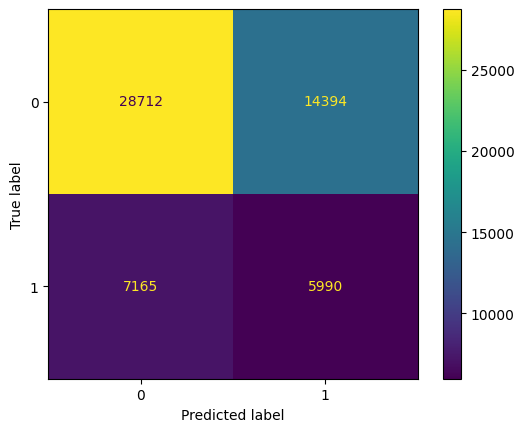

In [37]:
print_metrics_cv(best_svc,"SVC")
print("Testing:")
test_pred_svc = best_svc.predict(X_sc_test)

print_report_score(y_test,test_pred_svc)
print_confusion_matrix(y_test,test_pred_svc,best_svc)

Oversampling

In [ ]:
best_svc_ov = do_sklearn_GridSearchCV("SVC_OV",SVC(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

In [ ]:
print_metrics_cv(best_svc_ov,"SVC_OV")
print("Testing:")
test_pred_svc_ov = best_svc_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_svc_ov)
print_confusion_matrix(y_test,test_pred_svc_ov,best_svc_ov)

Undersampling

In [ ]:
best_svc_und = do_sklearn_GridSearchCV("SVC_UN",SVC(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

In [ ]:
print_metrics_cv(best_svc_und,"SVC_UN")
print("Testing:")
test_pred_svc_und = best_svc_und.predict(X_sc_test)

print_report_score(y_test,test_pred_svc_und)
print_confusion_matrix(y_test,test_pred_svc_und,best_svc_und)

In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_svc.values, s=25, cmap='YlGn')

## Rule-based classification

In order to run the RIPPER classifier, we run a grip search to find the best configuration parameter values.
In particular, the prune size defines the grow/prune proportion , while k is the number of optimization runs.

In [ ]:
import wittgenstein as lw

In [ ]:
params = {
    "unique_entry":{
    "prune_size": [0.5, 0.6], 
    "k": [1, 3, 5],
    "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2}],
    "random_state":[42]
    }}
best_ripper = do_sklearn_GridSearchCV("RIPPER",lw.RIPPER(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

We run the model using the configuration found with grid search.

In [ ]:
print_metrics_cv(best_ripper,"RIPPER")
print("Testing:")
test_pred_ripper = best_ripper.predict(X_sc_test)

print_report_score(y_test,test_pred_ripper)
print_confusion_matrix(y_test,test_pred_ripper,best_ripper)

The rules yielded by the RIPPER model are the following.

In [ ]:
best_ripper.out_model()

We predict the class values using the rules found above.

In order to evaluate the goodness of this classfication we compute the performance metrics.


with rule based classifiers it is possible to extract the reasons for the prediction.
only for the positive predictions

In [ ]:
best_ripper.predict(X_sc_test[:20], give_reasons=True) #Explain the rules behind the first 20 instances that are classified as positive.

oversample

In [ ]:
best_ripper_ov = do_sklearn_GridSearchCV("RIPPER_OV",lw.RIPPER(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

In [ ]:
print_metrics_cv(best_ripper_ov,"RIPPER_OV")
print("Testing:")
test_pred_ripper_ov = best_ripper_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_ripper_ov)
print_confusion_matrix(y_test,test_pred_ripper_ov,best_ripper_ov)

Undersample

In [ ]:
best_ripper_und = do_sklearn_GridSearchCV("RIPPER_UN",lw.RIPPER(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

In [ ]:
print_metrics_cv(best_ripper_und,"RIPPER_UN")
print("Testing:")
test_pred_ripper_und = best_ripper_und.predict(X_sc_test)

print_report_score(y_test,test_pred_ripper_und)
print_confusion_matrix(y_test,test_pred_ripper_und,best_ripper_und)

## Neural Network

imports of libraries to create NN

In [21]:
from sklearn.neural_network import MLPClassifier

We start by considering a neural network composed by one layer.

In [22]:
#custom mse metric for sklearn GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

custom_scores_mlp = {
    "accuracy": "accuracy",
    "mse": make_scorer(mean_squared_error,greater_is_better=False),
    'precision': 'precision',
    'recall': 'recall', 
    'f1':'f1', 
    'roc_auc': 'roc_auc'
}

In [23]:
# These parameters are a selection from a more coarse grid search
params = {
    "unique_entry":{
    "hidden_layer_sizes": [[64],[32,16],[16,32],[64, 32, 8]],
    "activation": ["tanh"],
    "solver": ["adam", "sgd"], 
    "alpha": [1e-5, 1e-8],
    "batch_size": [8, 16, 32],
    "learning_rate_init": [1e-2, 1e-3],
    "learning_rate": ['constant', 'adaptive'],
    "momentum": [0.0, 0.4, 0.8],
    "max_iter": [500]
}
}



In [24]:
best_mlp = do_sklearn_GridSearchCV("MLP",MLPClassifier(),list_grids(params), custom_scores_mlp,"mse",
                        cv_strategy,True,4,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[CV 3/5; 1/576] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, momentum=0.0, solver=adam
[CV 2/5; 1/576] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, momentum=0.0, solver=adam
[CV 4/5; 1/576] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, momentum=0.0, solver=adam
[CV 1/5; 1/576] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, momentum=0.0, solver=adam
[CV 3/5; 1/576] END activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64], learning_rate=constant, learning_rate_init=0.01, max_iter=500, momentum=0.0, solver=adam; accuracy: (train=0.754, test=0.755) f1: (train=0.339, test=0.345) mse: (train=-0.246, test=-0.245) pr

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 82/576] END activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64, 32, 8], learning_rate=constant, learning_rate_init=0.001, max_iter=500, momentum=0.4, solver=sgd; accuracy: (train=0.789, test=0.767) f1: (train=0.514, test=0.462) mse: (train=-0.211, test=-0.233) precision: (train=0.650, test=0.587) recall: (train=0.426, test=0.381) roc_auc: (train=0.831, test=0.794) total time=10.4min
[CV 2/5; 83/576] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64, 32, 8], learning_rate=constant, learning_rate_init=0.001, max_iter=500, momentum=0.8, solver=adam
[CV 4/5; 82/576] END activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64, 32, 8], learning_rate=constant, learning_rate_init=0.001, max_iter=500, momentum=0.4, solver=sgd; accuracy: (train=0.784, test=0.759) f1: (train=0.499, test=0.443) mse: (train=-0.216, test=-0.241) precision: (train=0.639, test=0.564) recall: (train=0.409, test=0.365) roc_auc: (train=0.826, test=0.787) total ti

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 84/576] END activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64, 32, 8], learning_rate=constant, learning_rate_init=0.001, max_iter=500, momentum=0.8, solver=sgd; accuracy: (train=0.803, test=0.748) f1: (train=0.563, test=0.445) mse: (train=-0.197, test=-0.252) precision: (train=0.677, test=0.530) recall: (train=0.482, test=0.383) roc_auc: (train=0.850, test=0.772) total time=10.1min
[CV 3/5; 86/576] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64, 32, 8], learning_rate=adaptive, learning_rate_init=0.01, max_iter=500, momentum=0.0, solver=sgd
[CV 5/5; 84/576] END activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64, 32, 8], learning_rate=constant, learning_rate_init=0.001, max_iter=500, momentum=0.8, solver=sgd; accuracy: (train=0.795, test=0.751) f1: (train=0.560, test=0.463) mse: (train=-0.205, test=-0.249) precision: (train=0.641, test=0.536) recall: (train=0.497, test=0.408) roc_auc: (train=0.839, test=0.781) total time

/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lau/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5; 89/576] END activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64, 32, 8], learning_rate=adaptive, learning_rate_init=0.01, max_iter=500, momentum=0.8, solver=adam; accuracy: (train=0.737, test=0.737) f1: (train=0.000, test=0.000) mse: (train=-0.263, test=-0.263) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.726, test=0.721) total time=  27.3s
[CV 2/5; 90/576] START activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64, 32, 8], learning_rate=adaptive, learning_rate_init=0.01, max_iter=500, momentum=0.8, solver=sgd
[CV 4/5; 88/576] END activation=tanh, alpha=1e-05, batch_size=8, hidden_layer_sizes=[64, 32, 8], learning_rate=adaptive, learning_rate_init=0.01, max_iter=500, momentum=0.4, solver=sgd; accuracy: (train=0.795, test=0.749) f1: (train=0.564, test=0.465) mse: (train=-0.205, test=-0.251) precision: (train=0.639, test=0.528) recall: (train=0.505, test=0.416) roc_auc: (train=0.850, test=0.774) total time=

KeyboardInterrupt: 

CV best configuration for MLP:
best parameters {'activation': 'tanh', 'hidden_layer_sizes': [12], 'solver': 'adam'}
Mean accuracy train set: 0.9758156657786389 +/- 0.0008790184644651324
Mean precision train set: 0.9292172775427512 +/- 0.004873355302818898
Mean recall train set: 0.9705408046913178 +/- 0.0018983497769820973
Mean f1 train set: 0.9494174070148697 +/- 0.0016584627698065831
Mean roc_auc train set: 0.9916394002253371 +/- 0.0005966266340014708
Mean mse train set: 0.024184334221361244 +/- 0.0008790184644651499


Mean accuracy validation set: 0.9756156785250031 +/- 0.0016118960822239065
Mean precision validation set: 0.928801257410733 +/- 0.005988434934929989
Mean recall validation set: 0.9701254275940707 +/- 0.0010736117969235232
Mean f1 validation set: 0.9490037758652432 +/- 0.003207127683471027
Mean roc_auc validation set: 0.9910278895518232 +/- 0.0009535141217984284
Mean mse train set: 0.024384321474996973 +/- 0.0016118960822238805


Testing:
              precision    recal

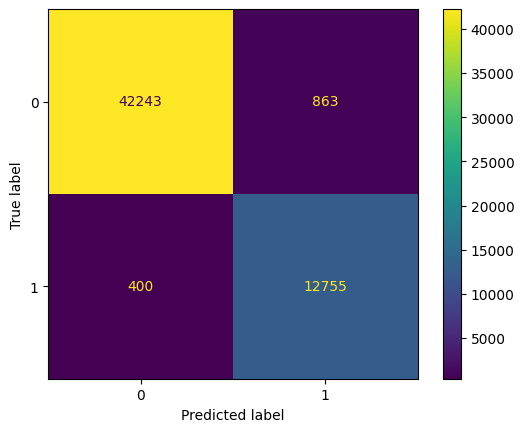

In [ ]:
print_metrics_cv(best_mlp,"MLP")
print("Testing:")
test_pred_mlp = best_mlp.predict(X_sc_test)

print_report_score(y_test,test_pred_mlp)
print_confusion_matrix(y_test,test_pred_mlp,best_mlp)

In [88]:
#pd.DataFrame(best_mlp.cv_results_).sort_values(by="mean_test_mse", ascending=False)[['mean_train_mse','mean_test_mse', 'mean_train_accuracy', 'mean_test_accuracy']]

mean_train_mse  mean_test_mse  mean_train_accuracy  mean_test_accuracy
0       -0.024184      -0.024384             0.975816            0.975616
1       -0.027157      -0.027142             0.972843            0.972858

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
""" #Reconstructing curve of best model
train_sizes, train_scores, test_scores = learning_curve( MLPClassifier(hidden_layer_sizes=[12], activation="tanh", 
                 solver="adam"), X_sc_trvl, y_trvl, cv=2, scoring=custom_scores_mlp["mse"])

train_scores_mean = np.mean(abs(train_scores), axis=1)
test_scores_mean = np.mean(abs(test_scores), axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, '-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, '-', color="r", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("MSE")
plt.legend(loc="best")
plt.title("Learning Curve for MLP")
plt.show() """

oversampling

In [ ]:
best_mlp_ov = do_sklearn_GridSearchCV("MLP_OV",MLPClassifier(),list_grids(params), custom_scores_mlp,"mse",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

In [ ]:
print_metrics_cv(best_mlp_ov,"MLP_OV")
print("Testing:")
test_pred_mlp_ov = best_mlp_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_mlp_ov)
print_confusion_matrix(y_test,test_pred_mlp_ov,best_mlp_ov)

undersampling

In [ ]:
best_mlp_und = do_sklearn_GridSearchCV("MLP_UN",MLPClassifier(),list_grids(params), custom_scores_mlp,"mse",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

In [ ]:
print_metrics_cv(best_mlp_und,"MLP_UN")
print("Testing:")
test_pred_mlp_und = best_mlp_und.predict(X_sc_test)

print_report_score(y_test,test_pred_mlp_und)
print_confusion_matrix(y_test,test_pred_mlp_und,best_mlp_und)

In [ ]:
""" from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import callbacks
from keras.losses import binary_crossentropy
def createModel(layersConfig,dropout, hiddenActv,outputActv):
  modelLayers = []
  print(layersConfig)
  # Input layer
  input_dim = X_sc_trvl.shape[1]
  modelLayers.append(Dense(input_dim, activation=hiddenActv, input_dim=input_dim))
  for units in layersConfig:
      modelLayers.append(Dropout(dropout)) # drop dropout_value% of units during learning, in order to reduce overfitting.
      modelLayers.append(Dense(units, activation=hiddenActv, input_dim=input_dim))
      input_dim = units
  # Output layer
  modelLayers.append(Dense(1, activation=outputActv))
  print(modelLayers)
  model = Sequential(modelLayers)
  return model


'''optimizers = ['sgd','adamax','adam']
loss_functions = ['mean_squared_error', 'binary_crossentropy']
'''
# Define a list of possible lists of number of units for each layer
layersConfig = [([42,12],0.1),([32,12],0.1),([24],0.1),([32],0.1),([12],0.1),([64, 24, 8],0.1)]
                #1) (input + 1) * 2, (input + 1) /2
                #2) (input + 10) + 1, (input - 10) + 1
                #3) random
                #4) random
                #5) (input + 1) /2
                #6) (input + 1) * 3, (input + 3), (input + 1) / 3 

model_information_list = []

for layer_config in layersConfig:
    model = createModel(layer_config[0],layer_config[1],"relu","sigmoid") # relu for hidden, sigmoid for output layer

    # Compile the Neural network model
    model.compile(optimizer='adam',
                  loss=binary_crossentropy, # suitable for binary classification
                  metrics=['accuracy']) # accuracy on test set to maximize
    
    # early loss calculated on validation set, we using the val_loss instead of training_loss because it's a value that better rappresents the efficacy of the model to generalize
    earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",        # quantity to be monitored (validation loss)
    mode="min",                # "min" means training will stop when the quantity monitored has stopped decreasing
    patience=3,                # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # whether to restore model weights from the epoch with the best value of the monitored quantity
    )
    # model training
    trainedModel = model.fit(X_sc_train, y_train, validation_data = (X_sc_val,y_val),epochs=80, batch_size=512, verbose=0, callbacks=[earlystopping]) #random values for epochs and batch_size

    # evaluate the model on the validation set
    _, accuracy = model.evaluate(X_sc_val, y_val, verbose=0)

    print('NN with ', layer_config, 'configuration - Validation Score:', accuracy,
        '- Epochs:', earlystopping.stopped_epoch)

    model_information_list.append({"earlyStopping":earlystopping,"trainedModel":trainedModel,"accuracyValidation":accuracy,"model":model})

    index_best_nn = 0 # the best nn on validation set is the first 1
best_history = model_information_list[index_best_nn]["trainedModel"]
best_model = model_information_list[index_best_nn]["model"]

best_model.summary()
plt.plot(best_history.history['loss']) 
plt.plot(best_history.history['val_loss']) 
plt.title('Val loss of best NN') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

# Builds NN architecture based on the best nn
model = createModel(layersConfig[index_best_nn][0],layersConfig[index_best_nn][1],"relu","sigmoid")
model.compile(optimizer='adam',
                  loss=binary_crossentropy, # suitable for binary classification
                  metrics=['accuracy']) # accuracy on test set to maximize

# Train the model on the development set
final_history = model.fit(X_sc_trvl, y_trvl, validation_data = (X_sc_test, y_test), epochs=20, batch_size=32, verbose=0)

# Evaluate the model on the test set
y_pred_test = np.rint(model.predict(X_sc_test, verbose=0))
 """

## Ensemble methods

### Random Forest

#### Grid search for parameter setting

In order to find the best parameters we use a grid search.
The parameters values we want to find are the following.

In [ ]:
params = {
    "unique_entry": {
    'max_depth': [5, 15, None],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [32, 64, 128],
    "bootstrap": [True, False],
    "criterion": ["entropy", "gini"],
    "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:2} ]
    }}

best_rf = do_sklearn_GridSearchCV("RandomForestClassifier",RandomForestClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .................................................... total time=  10.3s
[CV] END .................................................... total time=  10.5s
[CV] END .................................................... total time=  10.9s
[CV] END .................................................... total time=   9.7s
[CV] END .................................................... total time=  10.3s


We run the classifier and compute the perfomance scores.

CV best configuration for RandomForestClassifier:
best parameters {}
Mean accuracy train set: 0.999992382294548 +/- 3.8088527262552135e-06
Mean precision train set: 1.0 +/- 0.0
Mean recall train set: 0.9999674214041374 +/- 1.628929793127121e-05
Mean f1 train set: 0.9999837103703854 +/- 8.144814807264922e-06
Mean roc_auc train set: 1.0 +/- 0.0


Mean accuracy validation set: 0.981641321948101 +/- 0.0007511800122870125
Mean precision validation set: 0.9799129123245696 +/- 0.0013065745846530645
Mean recall validation set: 0.9407721127219417 +/- 0.0030362831874070064
Mean f1 validation set: 0.9599407325250787 +/- 0.001688847195041493
Mean roc_auc validation set: 0.9966432368685391 +/- 0.0003746763867394355


Testing:


              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.98      0.95      0.97     13155

    accuracy                           0.98     56261
   macro avg       0.98      0.97      0.98     56261
weighted avg       0.98      0.98      0.98     56261



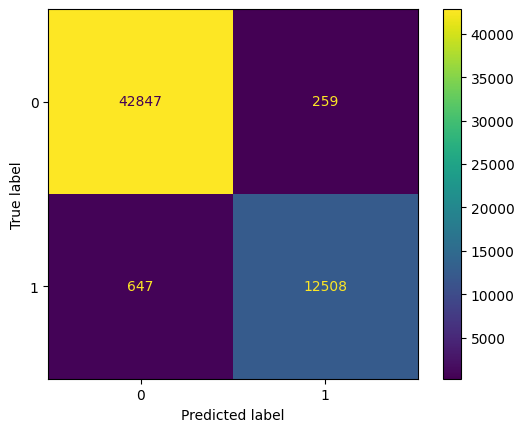

In [ ]:
print_metrics_cv(best_rf,"RandomForestClassifier")
print("Testing:")
test_pred_rf = best_rf.predict(X_sc_test)

print_report_score(y_test,test_pred_rf)
print_confusion_matrix(y_test,test_pred_rf,best_rf)

Oversampling

In [ ]:
best_rf_ov = do_sklearn_GridSearchCV("RandomForestClassifier_OV",RandomForestClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,3,X_sc_trvl_oversampled,y_trvl_oversampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for RandomForestClassifier_OV:
best parameters {}
Mean accuracy train set: 0.7472869350543025 +/- 0.0035881674653820204
Mean precision train set: 0.6755262791363921 +/- 0.0031232752368840237
Mean recall train set: 0.9517439259906961 +/- 0.0013639834406489074
Mean f1 train set: 0.7901899694428481 +/- 0.002579256998283355
Mean roc_auc train set: 0.8957640153162556 +/- 0.0009369164146972369


Mean accuracy validation set: 0.7469724862531922 +/- 0.005159216115391393
Mean precision validation set: 0.6752703022472477 +/- 0.004355558191444009
Mean recall validation set: 0.9515897879299813 +/- 0.002372455244529954
Mean f1 validation set: 0.7899607586952313 +/- 0.0037909706247199687
Mean roc_auc validation set: 0.8956185014373903 +/- 0.001499188440156002


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.97      0.96      0.97     13155

    accuracy                           0.99    

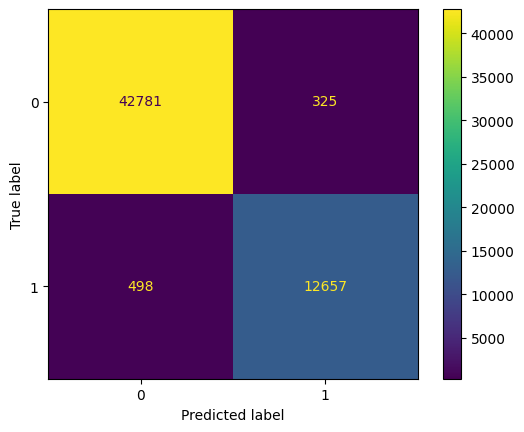

In [ ]:
print_metrics_cv(best_rf_ov,"RandomForestClassifier_OV")

print("Testing:")
test_pred_rf_over = best_rf_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_rf_over)
print_confusion_matrix(y_test,test_pred_rf_over,best_rf_ov)

undersampling

In [ ]:
best_rf_und = do_sklearn_GridSearchCV("RandomForestClassifier_UN",RandomForestClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_rf.values, s=25, cmap='YlGn')


CV best configuration for RandomForestClassifier_UN:
best parameters {}
Mean accuracy train set: 0.7472869350543025 +/- 0.0035881674653820204
Mean precision train set: 0.6755262791363921 +/- 0.0031232752368840237
Mean recall train set: 0.9517439259906961 +/- 0.0013639834406489074
Mean f1 train set: 0.7901899694428481 +/- 0.002579256998283355
Mean roc_auc train set: 0.8957640153162556 +/- 0.0009369164146972369


Mean accuracy validation set: 0.7469724862531922 +/- 0.005159216115391393
Mean precision validation set: 0.6752703022472477 +/- 0.004355558191444009
Mean recall validation set: 0.9515897879299813 +/- 0.002372455244529954
Mean f1 validation set: 0.7899607586952313 +/- 0.0037909706247199687
Mean roc_auc validation set: 0.8956185014373903 +/- 0.001499188440156002


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.97      0.96      0.97     13155

    accuracy                           0.99    

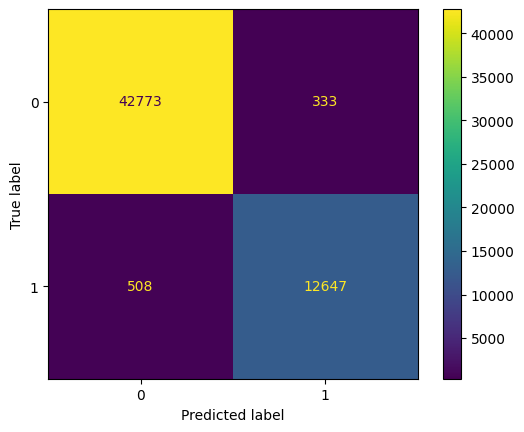

In [ ]:
print_metrics_cv(best_rf_und,"RandomForestClassifier_UN")

print("Testing:")
test_pred_rf_und = best_rf_und.predict(X_sc_test)

print_report_score(y_test,test_pred_rf_und)
print_confusion_matrix(y_test,test_pred_rf_und,best_rf_und)

### AdaBoost

Grid search AdaBoost

In [ ]:

def getAdaBoostBaseAlgo(num):
    if num == 0:
        return DecisionTreeClassifier(max_depth=5)
    elif num == 1:
        return SVC(kernel='rbf')
    elif num == 2:
        return RandomForestClassifier(max_depth=5)
    elif num == 3:
        return LogisticRegression()
                


In [ ]:
params = {
    "unique_entry":{
    'estimator': [getAdaBoostBaseAlgo(0),getAdaBoostBaseAlgo(1),getAdaBoostBaseAlgo(2),getAdaBoostBaseAlgo(3)],
    'n_estimators': [10,30,100], # The maximum number of estimators at which boosting is terminated.
    'learning_rate': [1,0.1],
    'random_state': [42],
    }
    }
best_ada_boost = do_sklearn_GridSearchCV("AdaBoostClassifier",AdaBoostClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl,y_trvl)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for AdaBoostClassifier:
best parameters {}
Mean accuracy train set: 0.9656022163767272 +/- 0.000552289984049151
Mean precision train set: 0.9845980054896895 +/- 0.002094314501342669
Mean recall train set: 0.8664521909105718 +/- 0.0027274968952139974
Mean f1 train set: 0.921749807047674 +/- 0.001331842809650927
Mean roc_auc train set: 0.9957042765084871 +/- 0.00010924750544593186


Mean accuracy validation set: 0.9653851232028167 +/- 0.0015436644230474575
Mean precision validation set: 0.9841238879446479 +/- 0.0018470343737416474
Mean recall validation set: 0.865939078025737 +/- 0.0069698401600212755
Mean f1 validation set: 0.9212390757030897 +/- 0.0037937212861665496
Mean roc_auc validation set: 0.9955492867529762 +/- 0.0002908172245548448


Testing:
              precision    recall  f1-score   support

   NotKilled       0.96      1.00      0.98     43106
    isKilled       0.98      0.87      0.92     13155

    accuracy                           0.97     56261

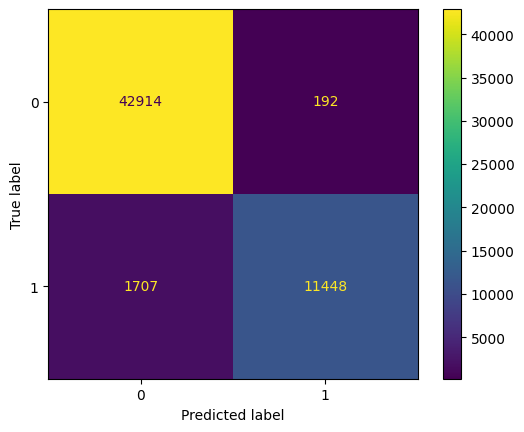

In [ ]:
print_metrics_cv(best_ada_boost,"AdaBoostClassifier")
print("Testing:")
test_pred_ada_boost = best_ada_boost.predict(X_sc_test)

print_report_score(y_test,test_pred_ada_boost)
print_confusion_matrix(y_test,test_pred_ada_boost,best_ada_boost)

Oversampling

In [ ]:
best_ada_boost_ov = do_sklearn_GridSearchCV("AdaBoostClassifier_OV",AdaBoostClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_oversampled,y_trvl_oversampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for AdaBoostClassifier_OV:
best parameters {}
Mean accuracy train set: 0.9735590811594964 +/- 0.0012201361355250512
Mean precision train set: 0.9868393443904301 +/- 0.0005547711576688695
Mean recall train set: 0.9599191726798655 +/- 0.0019934095522113433
Mean f1 train set: 0.9731924750601337 +/- 0.001257206335518299
Mean roc_auc train set: 0.9956742403819426 +/- 5.975593505442413e-05


Mean accuracy validation set: 0.9735081124442317 +/- 0.00127796892476267
Mean precision validation set: 0.9867042635179051 +/- 0.0009242597209341455
Mean recall validation set: 0.9599514770582177 +/- 0.0020365875755922283
Mean f1 validation set: 0.9731431696306793 +/- 0.0013123026908192722
Mean roc_auc validation set: 0.9956327291221518 +/- 0.00017370587718313756


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     

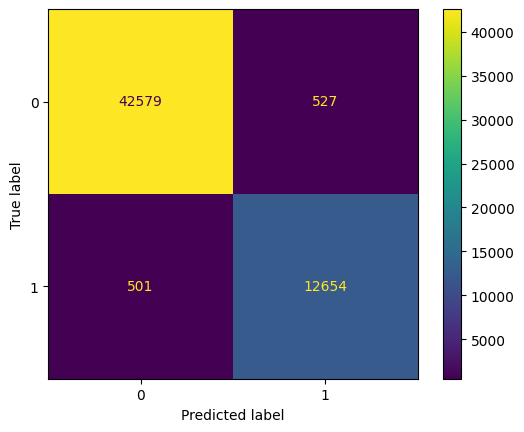

In [ ]:
print_metrics_cv(best_ada_boost_ov,"AdaBoostClassifier_OV")
print("Testing:")
test_pred_ada_boost_ov = best_ada_boost_ov.predict(X_sc_test)

print_report_score(y_test,test_pred_ada_boost_ov)
print_confusion_matrix(y_test,test_pred_ada_boost_ov,best_ada_boost_ov)

Undersampling

In [ ]:
best_ada_boost_und = do_sklearn_GridSearchCV("AdaBoostClassifier_UN",AdaBoostClassifier(),list_grids(params), ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy",
                        cv_strategy,True,5,X_sc_trvl_undersample,y_trvl_undersample)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


CV best configuration for AdaBoostClassifier_UN:
best parameters {}
Mean accuracy train set: 0.9735590811594964 +/- 0.0012201361355250512
Mean precision train set: 0.9868393443904301 +/- 0.0005547711576688695
Mean recall train set: 0.9599191726798655 +/- 0.0019934095522113433
Mean f1 train set: 0.9731924750601337 +/- 0.001257206335518299
Mean roc_auc train set: 0.9956742403819426 +/- 5.975593505442413e-05


Mean accuracy validation set: 0.9735081124442317 +/- 0.00127796892476267
Mean precision validation set: 0.9867042635179051 +/- 0.0009242597209341455
Mean recall validation set: 0.9599514770582177 +/- 0.0020365875755922283
Mean f1 validation set: 0.9731431696306793 +/- 0.0013123026908192722
Mean roc_auc validation set: 0.9956327291221518 +/- 0.00017370587718313756


Testing:
              precision    recall  f1-score   support

   NotKilled       0.99      0.99      0.99     43106
    isKilled       0.96      0.96      0.96     13155

    accuracy                           0.98     

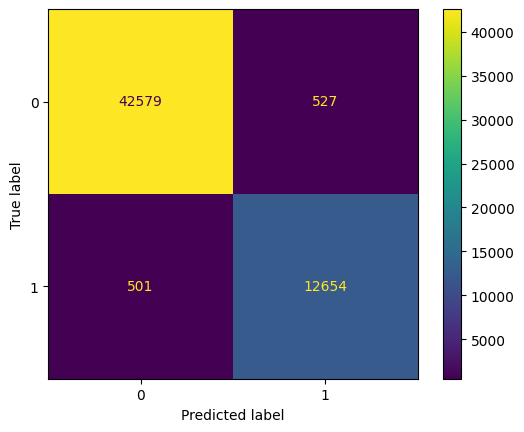

In [ ]:
print_metrics_cv(best_ada_boost_und,"AdaBoostClassifier_UN")
print("Testing:")
test_pred_ada_boost_und = best_ada_boost_und.predict(X_sc_test)

print_report_score(y_test,test_pred_ada_boost_und)
print_confusion_matrix(y_test,test_pred_ada_boost_und,best_ada_boost_und)

In [ ]:
#plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_ada_boost.values, s=25, cmap='YlGn')

## ROC Curve

We plot the ROC curve in order to estimate the goodness of our classification.

In [ ]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_ada_boost)
auc = metrics.roc_auc_score(y_test, test_pred_ada_boost)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_rf)
auc = metrics.roc_auc_score(y_test, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_dt)
auc = metrics.roc_auc_score(y_test, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_knn)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_svc)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_gnb)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_mlp)
auc = metrics.roc_auc_score(y_test, test_pred_mlp)
plt.plot(fpr,tpr,label="MLP, auc="+str(auc))

plt.legend(loc=0)